In [ ]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [1]:
if(!requireNamespace("BiocManager", quietly = TRUE)) {
 install.packages("BiocManager")
}
BiocManager::install("msqrob2")

install.packages("plotly")
BiocManager::install("ExploreModelMatrix")
install.packages('gridExtra')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'BiocVersion', 'msqrob2'

also installing the dependencies ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘clue’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘MultiAssayExperiment’, ‘S4Vectors’, ‘IRanges’, ‘BiocGenerics’, ‘ProtGenerics’, ‘AnnotationFilter’, ‘lazyeval’, ‘Biobase’, ‘MsCoreUtils’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘futile.logger’, ‘snow’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘GenomeInfoDb’, ‘DelayedArray’, ‘QFeatures’, ‘lme4’, ‘BiocParallel’, ‘limma’, ‘SummarizedExperiment’


Old packages: 'blob', 'broom', 'cli', 'credentials', 'googledrive',
  'googlesheets4', 'haven', 'openssl', 'pillar', 'readr', 'reprex',
  'rmark

## Francisella tularensis experiment

- pathogen: causes tularemia

- metabolic adaptation key for intracellular life cycle of pathogenic microorganisms

- upon entry into host cells quick phasomal escape and active multiplication in cytosolic compartment

- Franciscella is auxotroph for several amino acids, including arginine

- Inactivation of arginine transporter delayed bacterial phagosomal escape and intracellular multiplication

- experiment to assess difference in proteosoime using 3 WT vs 3 ArgP KO mutants

In [2]:
library(tidyverse)
library(limma)
library(QFeatures)
library(msqrob2)
library(plotly)
library(ggplot2)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MultiAssayExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    

In [ ]:
# 1. MS-data quantified w/ maxquant that contains MS1 intensities summarized at the peptide level
peptidesFile <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/francisella/peptides.txt"

# 2. retrieve the column names w/ the intensity data 
ecols <- grep("Intensity\\.", names(read.delim(peptidesFile)))

# 3. read the data and store in QFeatures object
pe <- readQFeatures(
  table = peptidesFile,
  fnames = 1,
  ecol = ecols,
  name = "peptideRaw", sep="\t")

# 4. update data w/ information on design
colData(pe)$genotype <- pe[[1]] %>%
  colnames %>%
  substr(12, 13) %>%
  as.factor %>%
  relevel('WT')

pe %>% colData

DataFrame with 6 rows and 1 column
                         genotype
                         <factor>
Intensity.1WT_20_2h_n3_3       WT
Intensity.1WT_20_2h_n4_3       WT
Intensity.1WT_20_2h_n5_3       WT
Intensity.3D8_20_2h_n3_3       D8
Intensity.3D8_20_2h_n4_3       D8
Intensity.3D8_20_2h_n5_3       D8

In [ ]:
# preprocessing 
# a) calculate no of non-zero intensities for each peptide

rowData(pe[["peptideRaw"]])$nNonZero <- rowSums(assay(pe[["peptideRaw"]]) > 0)

# b) convert 0 to NA for zero intensities i.e. missing peptides
pe <- zeroIsNA(pe, 'peptideRaw') 

# c) convert to log2
pe <- logTransform(pe, base = 2, i = 'peptideRaw', name = 'peptideLog')

In [ ]:
# filtering
# a) overlapping protein groups
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Proteins %in% 
                      smallestUniqueGroups(rowData(pe[["peptideLog"]])$Proteins),]

# b) remove reverse/decoy sequences and contaminants
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Reverse != "+", ]
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Contaminant != "+", ]

# c) drop peptides that were only identified in one sample
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$nNonZero >= 2, ]
nrow(pe[["peptideLog"]])



[1] 6525

In [ ]:
# normalization by median centering
pe <- normalize(pe, 
                i = "peptideLog", 
                name = "peptideNorm", 
                method = "center.median")

In [ ]:
options(warn=-1)
# summarization by robust summarization method
pe <- aggregateFeatures(pe,
      i = 'peptideNorm',
      fcol = 'Proteins',
      na.rm = T,
      name = 'protein')

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.



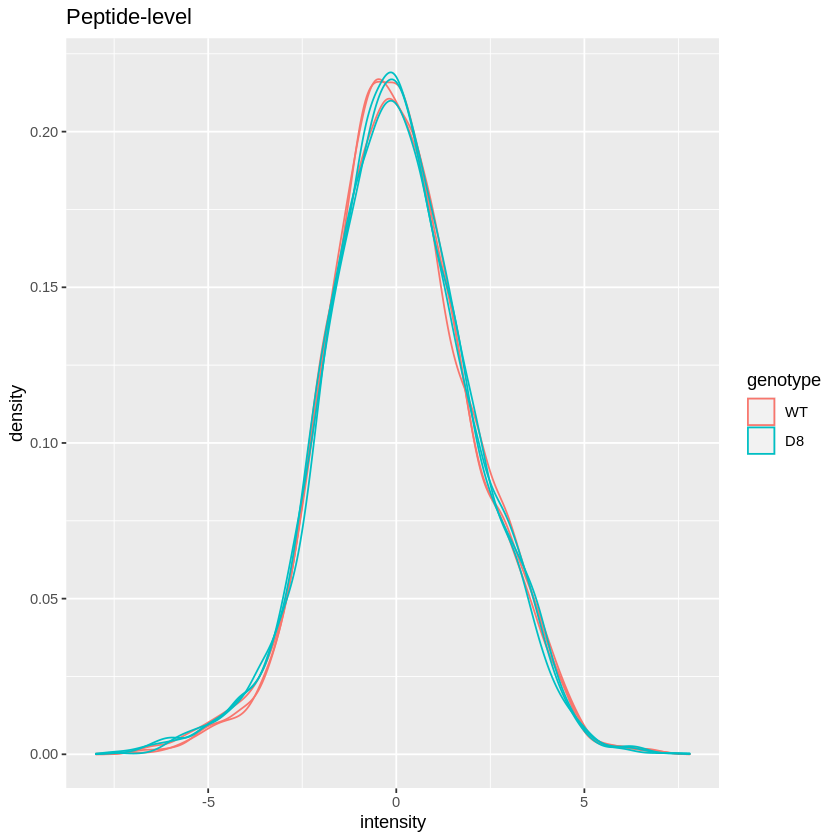

In [ ]:
# plot of preprocessed data
pe[['peptideNorm']] %>%
  assay %>%
  as.data.frame() %>%
  gather(sample, intensity) %>%
  mutate(genotype = colData(pe)[sample, 'genotype']) %>%
  ggplot(aes(x = intensity, group = sample, color = genotype)) + 
    geom_density() + 
    ggtitle('Peptide-level')

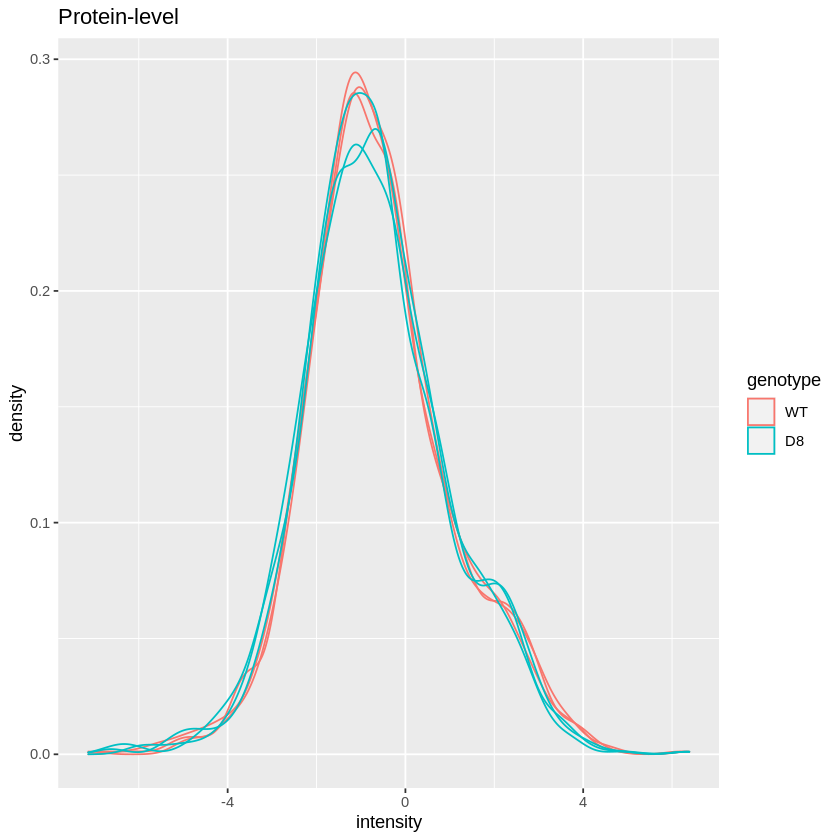

In [ ]:
pe[['protein']] %>%
  assay %>%
  as.data.frame() %>%
  gather(sample, intensity) %>%
  mutate(genotype = colData(pe)[sample, 'genotype']) %>%
  ggplot(aes(x = intensity, group = sample, color = genotype)) + 
    geom_density() + 
    ggtitle('Protein-level')

In [ ]:
# design
pe %>%
  colData %>%
  knitr::kable()




|                         |genotype |
|:------------------------|:--------|
|Intensity.1WT_20_2h_n3_3 |WT       |
|Intensity.1WT_20_2h_n4_3 |WT       |
|Intensity.1WT_20_2h_n5_3 |WT       |
|Intensity.3D8_20_2h_n3_3 |D8       |
|Intensity.3D8_20_2h_n4_3 |D8       |
|Intensity.3D8_20_2h_n5_3 |D8       |

In [ ]:
# summarized intensity matrix
pe[['protein']] %>% assay() %>% head() %>% knitr::kable()



|             | Intensity.1WT_20_2h_n3_3| Intensity.1WT_20_2h_n4_3| Intensity.1WT_20_2h_n5_3| Intensity.3D8_20_2h_n3_3| Intensity.3D8_20_2h_n4_3| Intensity.3D8_20_2h_n5_3|
|:------------|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|
|WP_003013731 |               -0.2748775|               -0.0856247|                0.1595370|               -0.2809009|                0.0035526|                0.0567110|
|WP_003013860 |                       NA|                       NA|               -0.2512039|                       NA|                       NA|               -0.4865646|
|WP_003013909 |               -0.6851118|               -0.8161658|               -0.7557906|               -0.4591476|               -0.5449424|               -0.4962482|
|WP_003014068 |                0.6495386|                0.8522239|                1.1344852|                0.5459176|                0.9

What is the effect of arginine deficiency in the population?


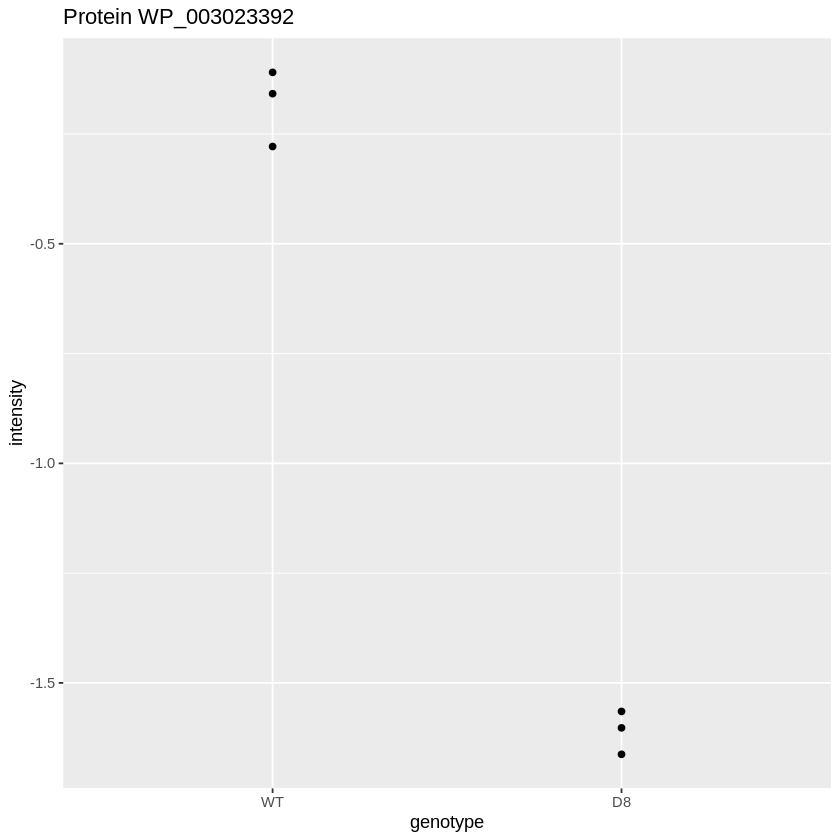

In [ ]:
WP_003023392 <- data.frame(intensity = assay(pe[['protein']]['WP_003023392',]) %>% c(),
                          genotype = colData(pe)[, 1])

WP_003023392 %>%
  ggplot(aes(x = genotype, y = intensity)) + 
  geom_point() + 
  ggtitle('Protein WP_003023392')

$t = \frac{log2FC}{se log2FC} = \frac{-1.43}{0.0577} = -24.7$

how likely is it to observe t = -24.7 when there is no effect of the argP KO on the protein expression?

H0 vs H1

- w/ data we can never prove a hypothesis

- we can only reject a hypothesis

- in general, we start from alternative hypothesis H1: we want to show an effect of the KO on a protein

H1: on average the protein abundance in WT is different from that in KO

- but, we'll assess the falsifying opposite:

H0: on average the protein abundance in WT is equal to that in KO

In [ ]:
t.test(intensity ~ genotype, data = WP_003023392, var.equal = T)


	Two Sample t-test

data:  intensity by genotype
t = 24.747, df = 4, p-value = 1.582e-05
alternative hypothesis: true difference in means between group WT and group D8 is not equal to 0
95 percent confidence interval:
 1.267666 1.588058
sample estimates:
mean in group WT mean in group D8 
      -0.1821147       -1.6099769 


- how likely is it to observe an equal or more extreme effect than the one observed in the sample when H0 is true?

- when we make assumptions about the distirbution of our test statistic we can quantify this probability: p-value. the p-value will only be calculated correctly if the underlying assumptions hold!

- when we repeat the experiment, the probability to observe a fold change for this gene that is more extreme than 2.69 fold down or up regulation by random change (if H0 is true) is 16 out of 1000 000

- if the p-value is below a significance threshold $\alpha$ we reject the H0. We control the probability on a FP result at the $\alpha$-level (Type I error)

- note, that the p-values are uniform under HO, i.e. when H0 is true all p-values are equally likely

### Multiple testing

1) Family-wise error rate

- no longer controlling the individual Type I error for each protein, instead it controls:

$FWER = P[FP \geq 1]$

the bonferroni method is widely used to control the Type I error:

- assess each test at $\alpha_{adj} = \frac{\alpha}{m}$

- or use adjusted p-values $p_{adj} = min(p \times m, 1)$

2) FDR

- expected proportion of false +ves on the total no of +ves you return

- an FDR of 1% means that on average we expect 1% FP proteins in the list of proteins that are called significant

- $FDP = \frac{FP}{R}$, yet this quantity cannot be observed because in practice we only know no of proteins for which we rejected H0, R

- but we don't know the no of false positives, FP

BH defined 

$FDR = E[\frac{FP}{R}] = E[FDP]$

- controlling the FDR allows for more discoveries (i.e. longer lists w/ significant results), while the fraction of false discoveries among the significant results in well controlled on average -> more True positives will be detected

BH procedure for controlling FDR at $\alpha$

1. let $p_1 \leq p_2 \leq \dots \leq p_m$

2. find $k_{max}$ such that $\frac{p_k \times m}{k} \leq \alpha$ or $p_k \leq k \times \frac{\alpha}{m}$

3. if such $k$ exists, reject the $k$ H0 associated with $p_1, \dots, p_k$. otherwise, none of H0 is rejected

adjusted p-value (also known as q-value):

$q_i = p_i = min[min_{j} (m \times p_j / j), 1]$



In [ ]:
ttestMx <- function(y, group) {
  test <- try(t.test(y[group], y[!group], var.equal = T), silent = T)
  if(is(test, 'try-error')) {
    return(c(log2FC = NA, se=NA, tstat=NA, p=NA))
  } else {
    return(c(log2FC = (test$estimate%*%c(1, -1)), se = test$stderr,
                      tstat=test$statistic, pval=test$p.value))
  }
}

In [ ]:
res <- apply(assay(pe[['protein']]),
            1, ttestMx,
            group = colData(pe)$genotype=='D8') %>% t
            

In [ ]:
colnames(res) <- c('logFC', 'se', 'tstat', 'pval')
res <- res %>%
  as.data.frame %>%
  na.exclude %>%
  arrange(pval)
res$adjPval <- p.adjust(res$pval, 'fdr')
alpha <- 0.05

res$adjAlphaForm <- paste0(1:nrow(res), ' x ', alpha, '/', nrow(res))
res$adjAlpha <- alpha * (1:nrow(res)) / nrow(res)
res$"pval < adjAlpha" <- res$pval < res$adjAlpha
res$"adjPval < alpha" <- res$adjPval < alpha

In [ ]:
res

,logFC,se,tstat,pval,adjPval,adjAlphaForm,adjAlpha,pval < adjAlpha,adjPval < alpha
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>,<lgl>
WP_003038940,-0.2876290,0.01139673,-25.237849,1.463558e-05,0.00843468,1 x 0.05/1066,4.690432e-05,TRUE,TRUE
WP_003023392,-1.4278622,0.05769817,-24.747096,1.582491e-05,0.00843468,2 x 0.05/1066,9.380863e-05,TRUE,TRUE
WP_003039212,-0.2658247,0.01626508,-16.343278,8.204119e-05,0.02915197,3 x 0.05/1066,1.407129e-04,TRUE,TRUE
WP_003026016,-1.0800305,0.07559952,-14.286209,1.394533e-04,0.03461237,4 x 0.05/1066,1.876173e-04,TRUE,TRUE
WP_003039615,-0.3992190,0.02904541,-13.744649,1.623469e-04,0.03461237,5 x 0.05/1066,2.345216e-04,TRUE,TRUE
WP_011733588,-0.4323262,0.03433936,-12.589814,2.290999e-04,0.04070341,6 x 0.05/1066,2.814259e-04,TRUE,TRUE
WP_003014552,-0.9843865,0.08532718,-11.536611,3.223975e-04,0.04402655,7 x 0.05/1066,3.283302e-04,TRUE,TRUE
WP_003040849,-1.2780743,0.11148301,-11.464296,3.304056e-04,0.04402655,8 x 0.05/1066,3.752345e-04,TRUE,TRUE
WP_003038430,-0.4331987,0.04091777,-10.587053,4.504550e-04,0.04890776,9 x 0.05/1066,4.221388e-04,FALSE,TRUE


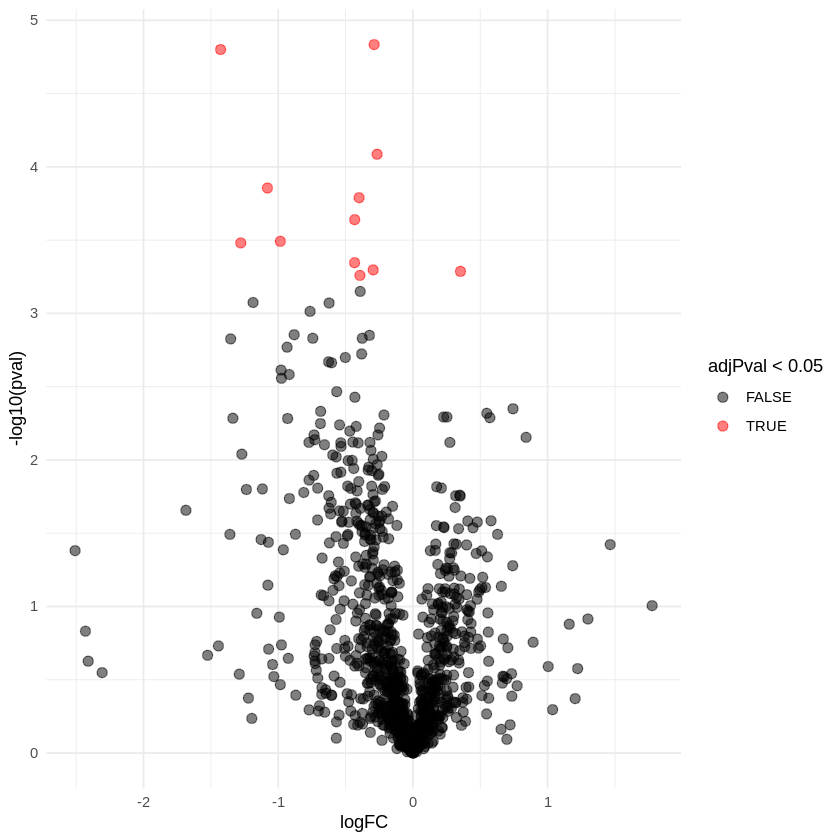

In [ ]:
volcanoT <- res %>% 
  ggplot(aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)) +
    geom_point(cex = 2.5) +
    scale_color_manual(values = alpha(c("black", "red"), 0.5)) +
    theme_minimal() 

volcanoT

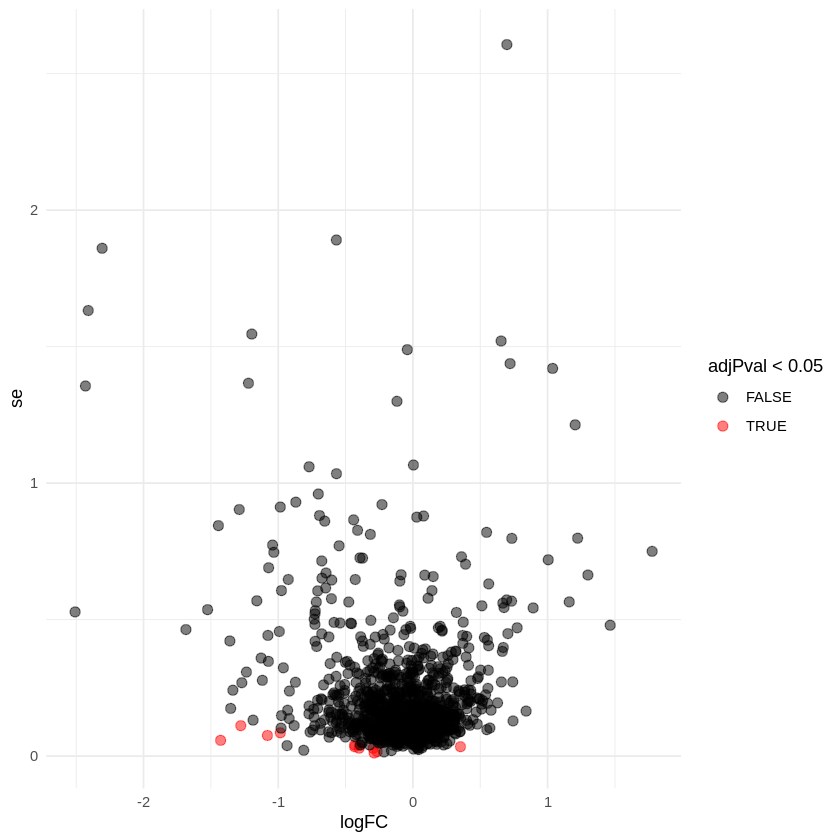

[[1]]

[[2]]

[[3]]


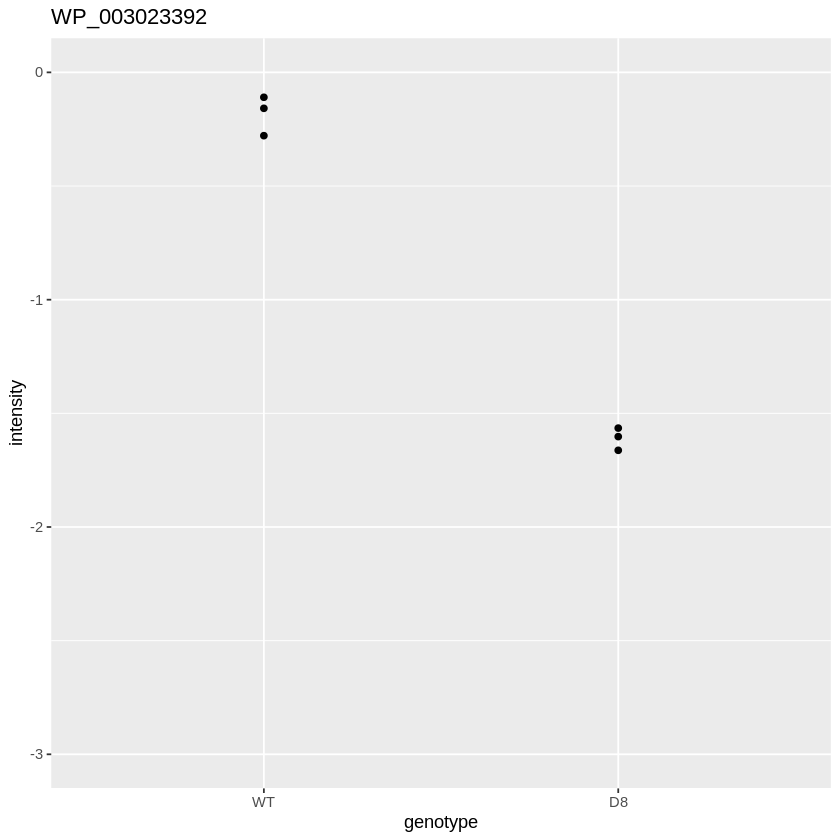

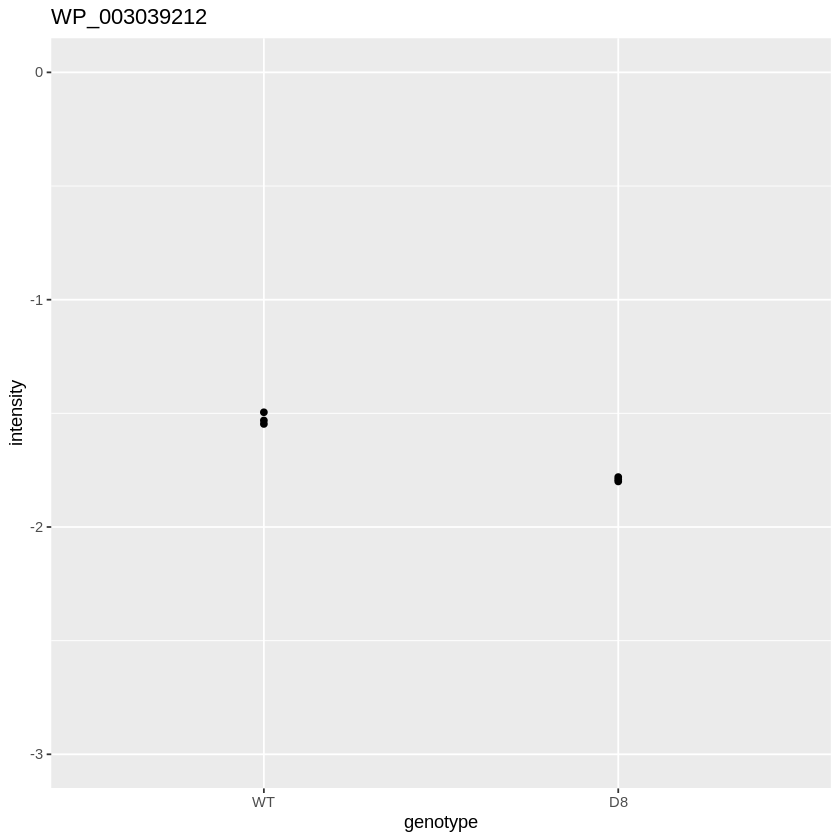

In [ ]:
problemPlots <- list() 
problemPlots[[1]] <- res %>% 
  ggplot(aes(x = logFC, y = se, color = adjPval < 0.05)) +
    geom_point(cex = 2.5) +
    scale_color_manual(values = alpha(c("black", "red"), 0.5)) +
    theme_minimal() 

for (i in 2:3)
{
problemPlots[[i]] <- colData(pe) %>% 
    as.data.frame %>% 
    mutate(intensity = pe[["protein"]][rownames(res)[i],] %>% 
             assay %>% 
             c) %>% 
    ggplot(aes(x=genotype,y=intensity)) +
    geom_point() + 
    ylim(-3,0) +
    ggtitle(rownames(res)[i])
}

problemPlots

to solve this problem w/ normal t-test, use moderated test statistics

$T_g^{mod} = \frac{\bar{Y}_{g1} - \bar{Y}_{g2}}{C. \tilde{S}_g}$

where $\tilde{S}_g$ is a moderated standard deviation estimate

- C is a constant depending on the design e.g. $\sqrt{1/n_1 + 1/n_2}$ for a t-test and of another form of linear models

- $\tilde{S}_g = S_g + S_0$: add small +ve constant to denominator of t-statistic


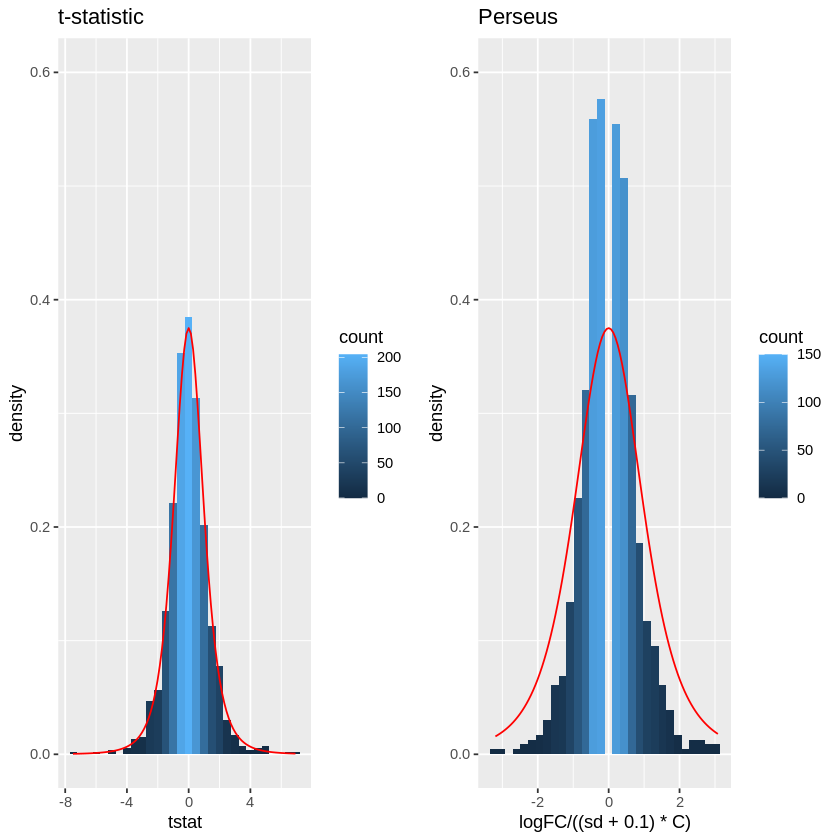

In [ ]:
simI<-sapply(res$se/sqrt(1/3+1/3),function(n,mean,sd) rnorm(n,mean,sd),n=6,mean=0) %>% t
resSim <- apply(
    simI, 
    1, 
    ttestMx,
    group = colData(pe)$genotype=="D8") %>% 
  t 
 colnames(resSim) <- c("logFC","se","tstat","pval")
 resSim <- as.data.frame(resSim)
 tstatSimPlot <- resSim %>% 
   ggplot(aes(x=tstat)) +
     geom_histogram(aes(y=..density.., fill=..count..),bins=30) +
     stat_function(fun=dt,
    color="red",
    args=list(df=4)) + 
   ylim(0,.6) +
   ggtitle("t-statistic")

 
 resSim$C <- sqrt(1/3+1/3) 
 resSim$sd <- resSim$se/resSim$C 
 tstatSimPerseus <- resSim %>% 
   ggplot(aes(x=logFC/((sd+.1)*C))) +
     geom_histogram(aes(y=..density.., fill=..count..),bins=30) +
     stat_function(fun=dt,
                   color="red",
                  args=list(df=4)) + 
     ylim(0,.6) +
    ggtitle("Perseus")

gridExtra::grid.arrange(tstatSimPlot, tstatSimPerseus, nrow=1)

- choice of $S_0$ in Perseus is ad hoc and the t-stats is no longer t-distributed

- permutation test, but is difficult for more complex designs

- allows for data dredging because user can choose $S_0$


3) Empirical Bayes

- provides formal framework for borrowing strength across proteins

- $\tilde{S}_g = \sqrt{\frac{d_gS_g^2 + d_0S_0^2}{d_g + d_0}}$

- $S_0^2$: common variance (over all proteins)

- moderated t-stat is t-distributed w/ $d_0 + d_g$ degrees of freedom

- degrees of freedom increase by borrowing strength across proteins

In [ ]:
# model protein level using robust regression

pe <- msqrob(object = pe, i = 'protein', formula = ~genotype)

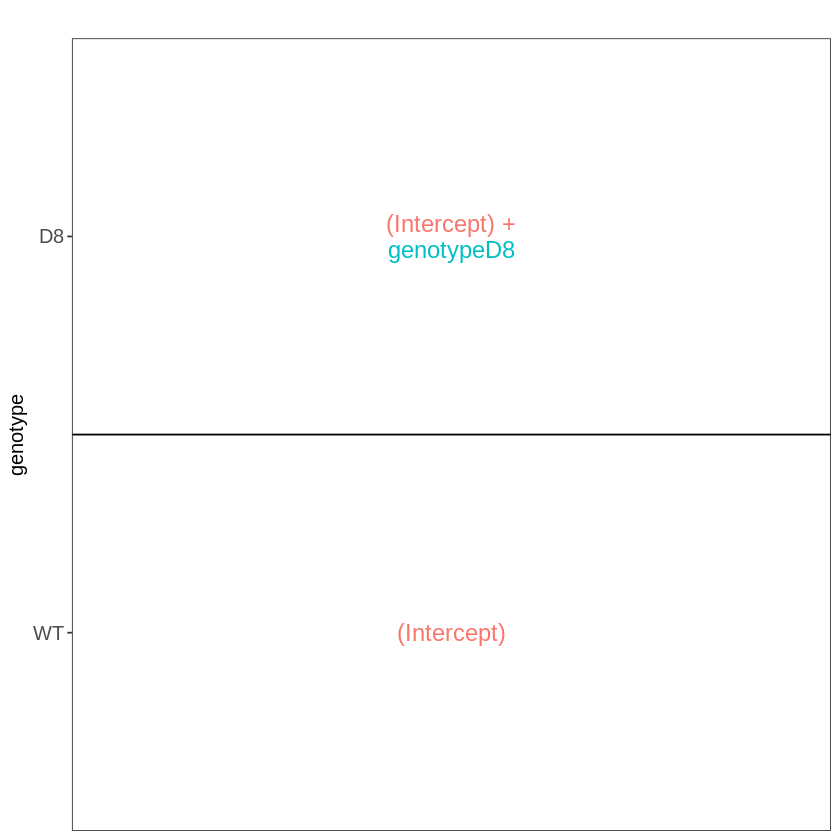

In [ ]:
library(ExploreModelMatrix)
VisualizeDesign(colData(pe),~genotype)$plotlist[[1]]

have 2 model parameters, the (intercepty) and genotypeD8 -> results in a model w/ 2 group means:

1. for WT, the expected value (mean) of the log2 transformed intensity y for a protein will be modelled using, $E[Y|genotype = WT] = (Intercept)$

2. for KO genotype D8, epected value (mean) of the log2 transformed intensity y for a protein will be modelled using $E[Y|genotype = D8] = (Intercept) + genotypeD8$

average log2FC between D8 and WT is thus
$log_2 FC_{D8-WT} = genotypeD8$

Hence, assessing the H0 that there's no DA between D8 and WT is that $H0: genotypeD8 = 0$

In [ ]:
L <- makeContrast('genotypeD8 = 0', parameterNames = c('genotypeD8'))
pe <- hypothesisTest(object = pe, i = 'protein', contrast = L)

In [ ]:
rowData(pe[['protein']])$genotypeD8 %>%
  arrange(pval) %>%
  filter(adjPval < 0.05)

,logFC,se,df,t,pval,adjPval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_003023392,-1.4278622,0.09546104,6.353267,-14.957538,3.435824e-06,0.003456439
WP_003040849,-1.2857733,0.12226820,6.236222,-10.516007,3.372825e-05,0.016965307
WP_003014552,-0.9843865,0.10770682,6.353267,-9.139501,6.920701e-05,0.022593404
WP_003033719,-1.1970073,0.13408775,6.220667,-8.927044,8.983461e-05,0.022593404
WP_003040790,-1.3531336,0.16187947,6.353267,-8.358896,1.174333e-04,0.023627585
WP_003026016,-1.0584448,0.11240892,5.442252,-9.416022,1.429981e-04,0.023976009
WP_003033905,-0.8815374,0.12199689,6.353267,-7.225901,2.740575e-04,0.039385984
WP_003039713,-0.7635044,0.10902744,6.353267,-7.002865,3.279672e-04,0.041241874
WP_003039530,-0.9184399,0.13755363,6.353267,-6.676959,4.299645e-04,0.041477282


In [ ]:
volcano <- ggplot(
    rowData(pe[["protein"]])$genotypeD8,
    aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)
) +
    geom_point(cex = 2.5) +
    scale_color_manual(values = alpha(c("black", "red"), 0.5)) +
    theme_minimal() +
    ggtitle("msqrob2")

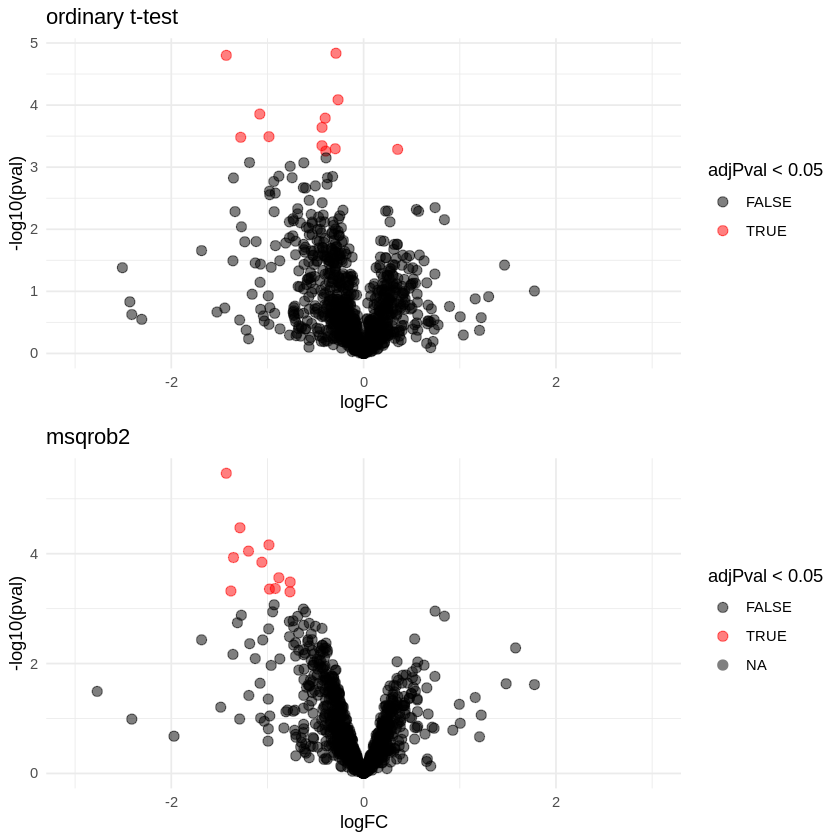

In [ ]:
gridExtra::grid.arrange(
  volcanoT +    
    xlim(-3,3) +
  ggtitle("ordinary t-test"),
  volcano +     
    xlim(-3,3)
,nrow=2)

- volcano plot opens up when using the EB variance estimator

- borrowing strength to estimate the variance using EB solves the issue of returning proteins w/ a low FC as significant due to a low variance

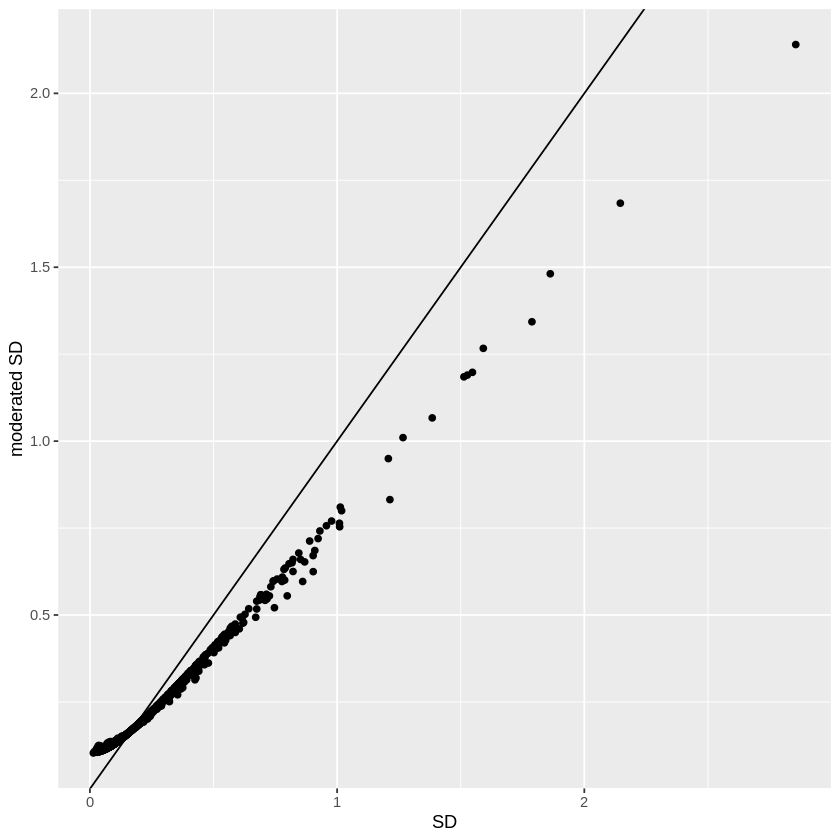

In [ ]:
# shrinkage of the variance and moderated t-statistics
qplot(
  sapply(rowData(pe[["protein"]])$msqrobModels,getSigma),
  sapply(rowData(pe[["protein"]])$msqrobModels,getSigmaPosterior)) +
  xlab("SD") +
  ylab("moderated SD") +
  geom_abline(intercept = 0,slope = 1) +
  geom_hline(yintercept = ) 

- small variances are shrunken towards the common variance -> large EB variance estimates

- large variances are shrunken towards the common variance -> small EB variance estiamtes

- pooled degrees of freedom of the EB variance estimator are larger bc information is borrowed across proteins to estimate the variance

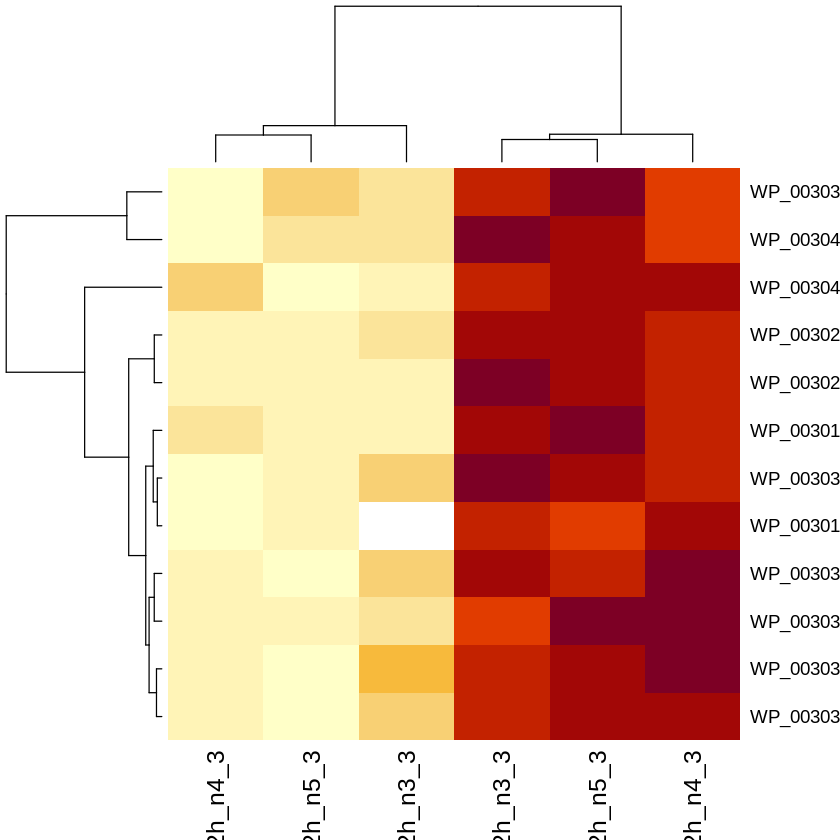

In [ ]:
sigNames <- rowData(pe[["protein"]])$genotypeD8 %>%
    rownames_to_column("protein") %>%
    filter(adjPval < 0.05) %>%
    pull(protein)
heatmap(assay(pe[["protein"]])[sigNames, ])

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



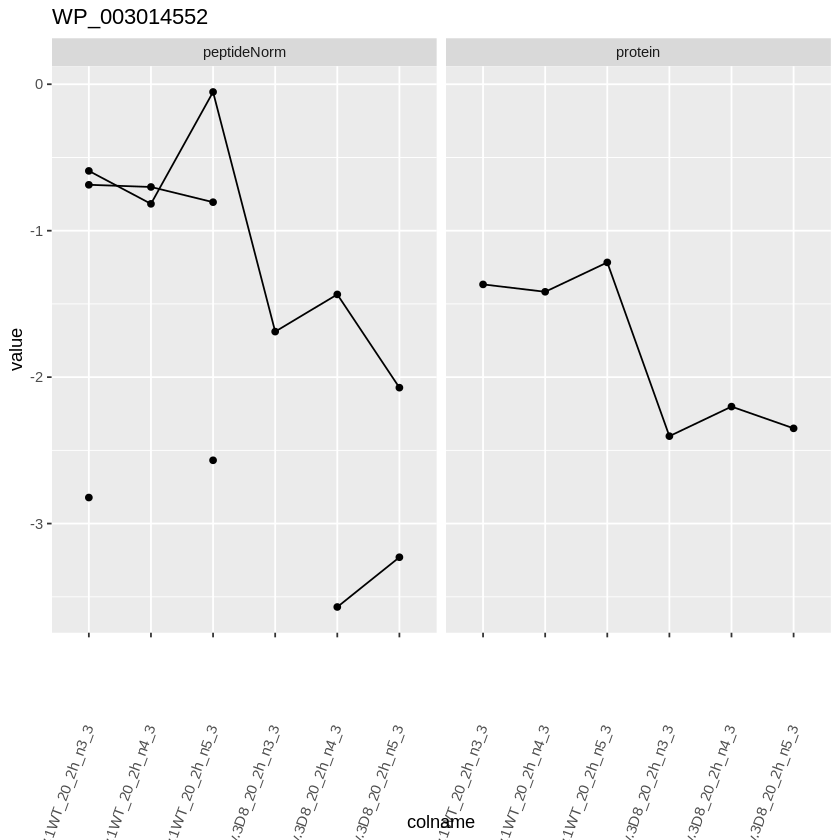

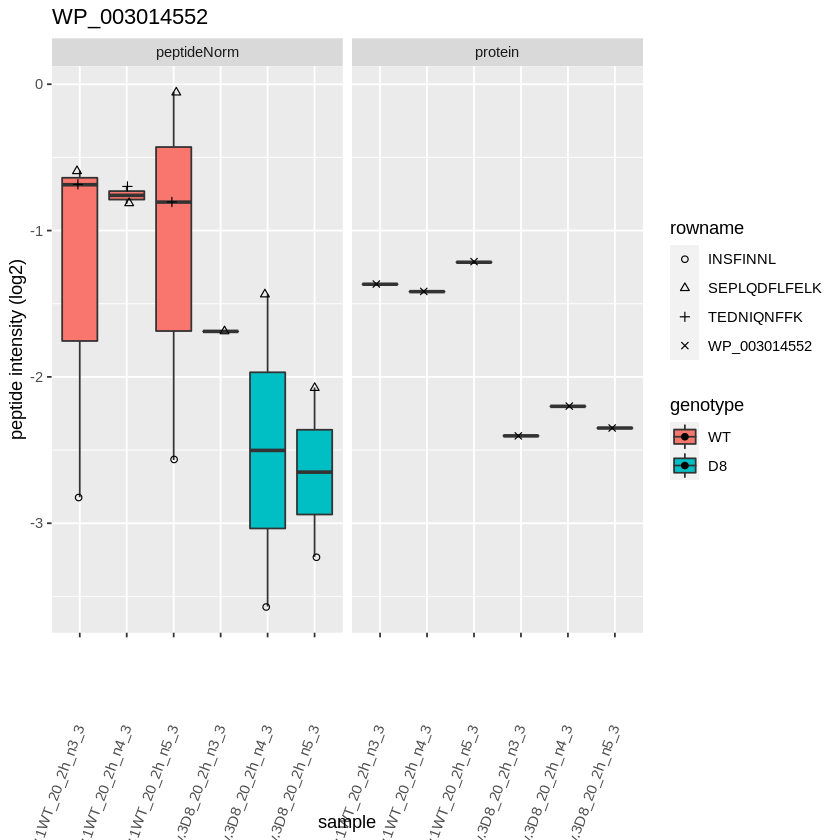

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



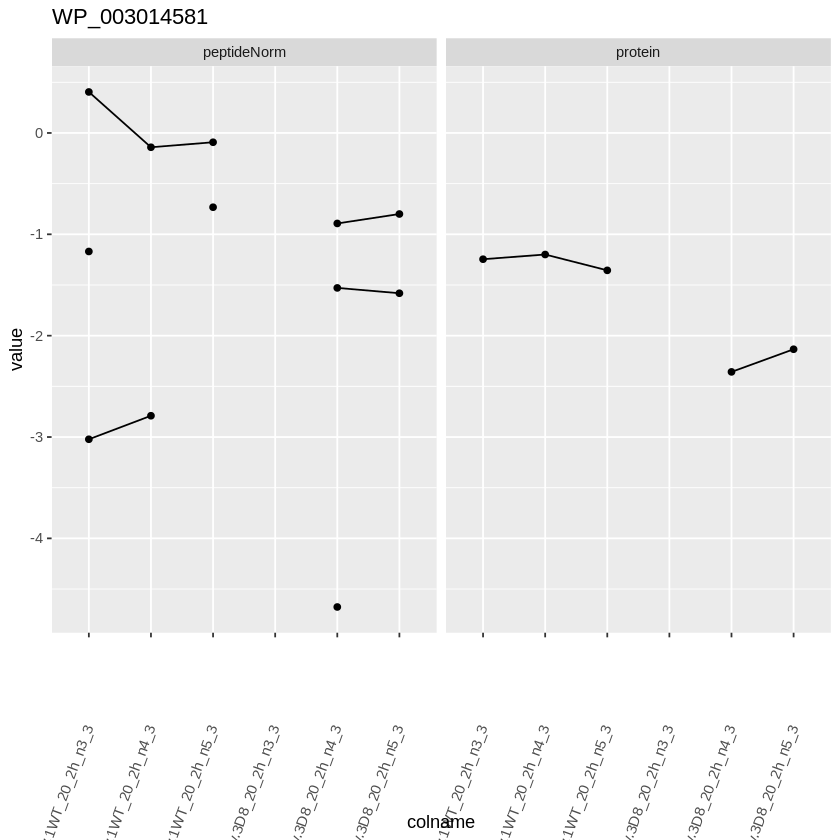

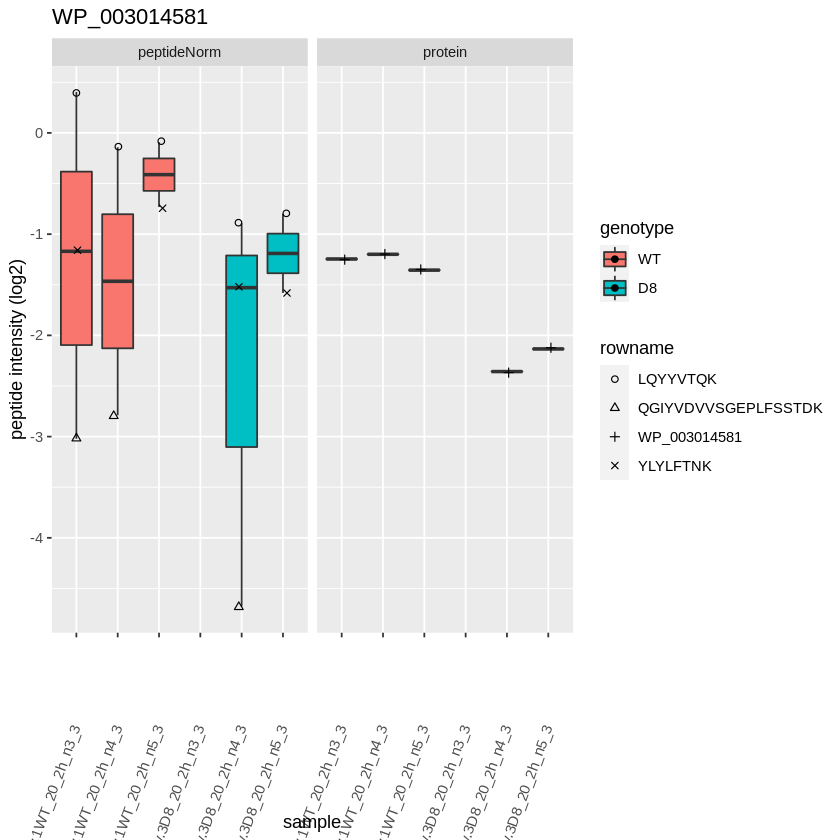

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



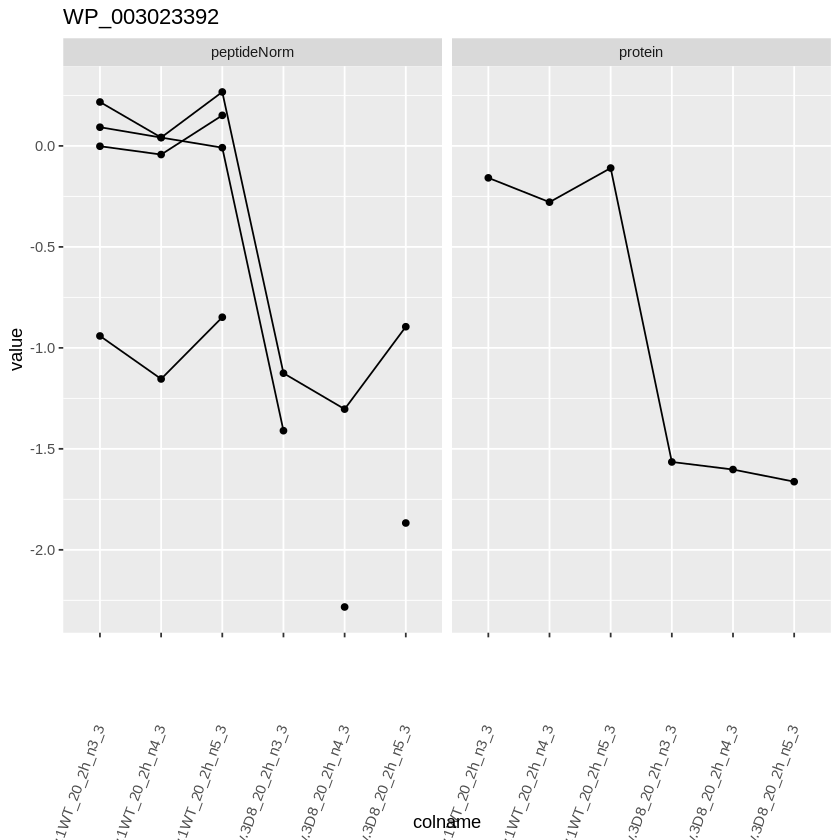

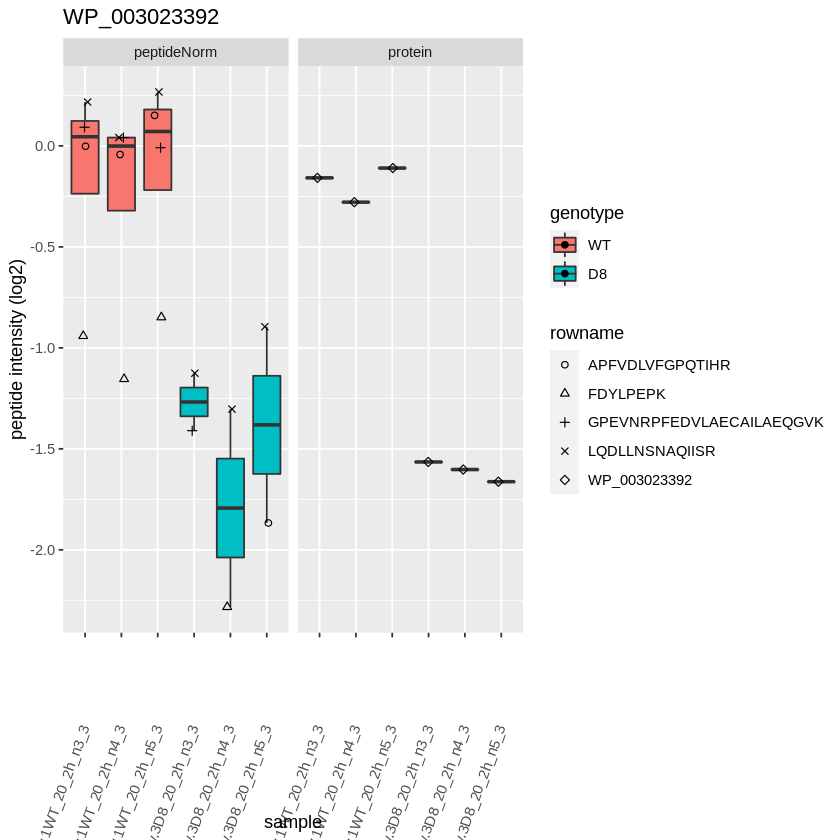

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



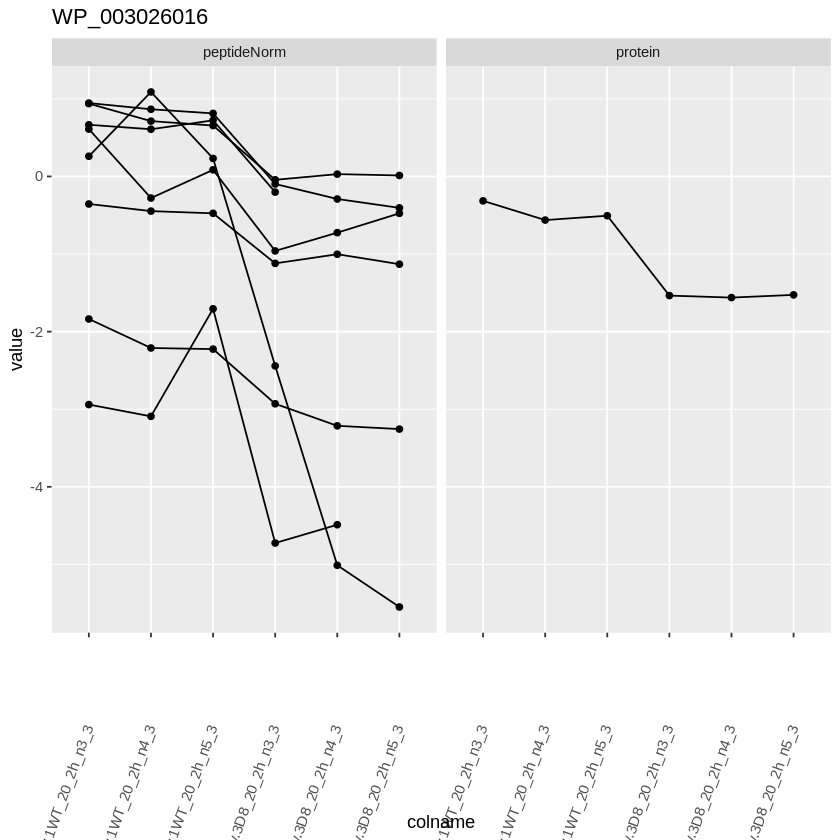

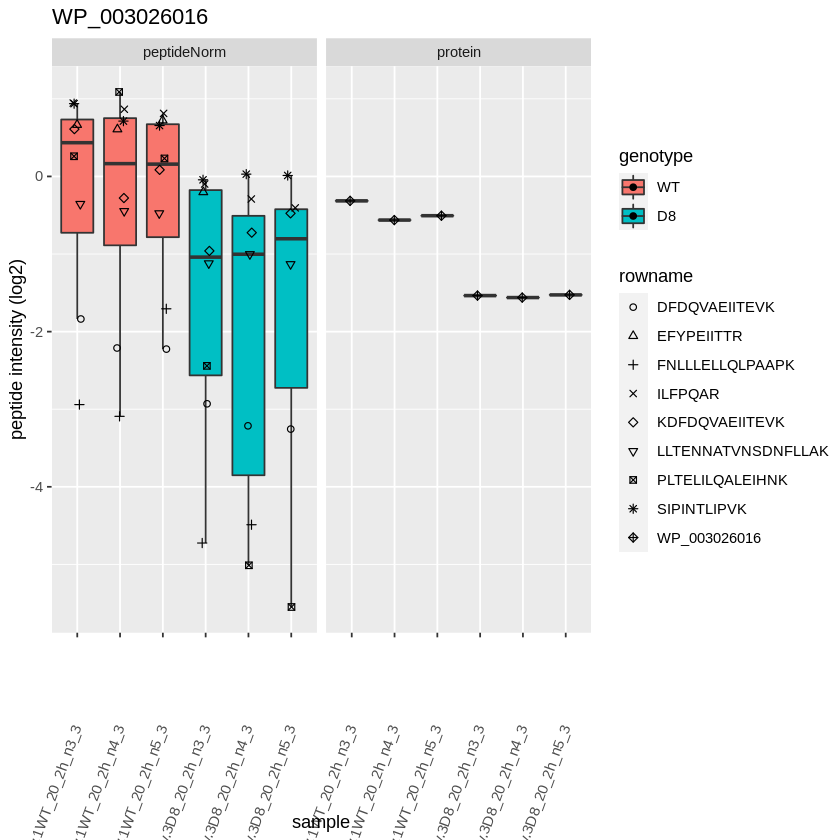

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



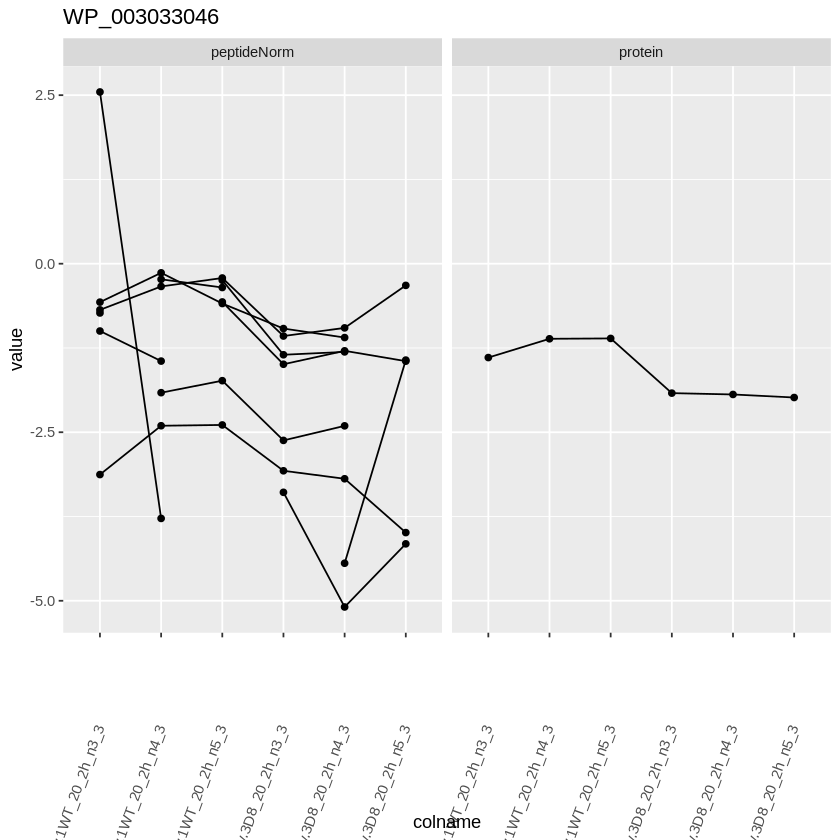

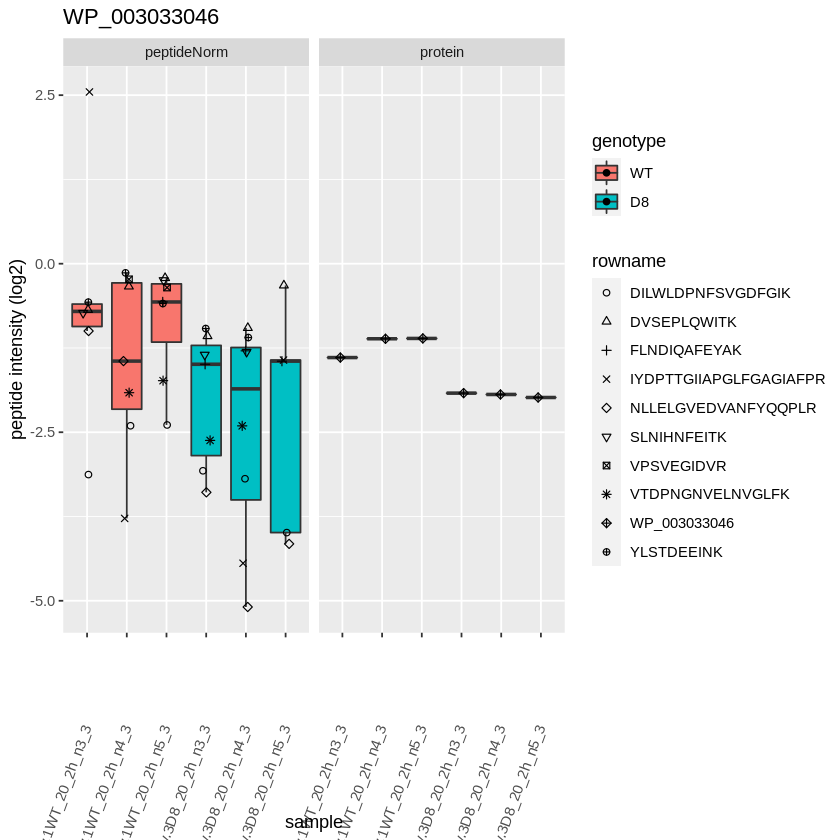

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



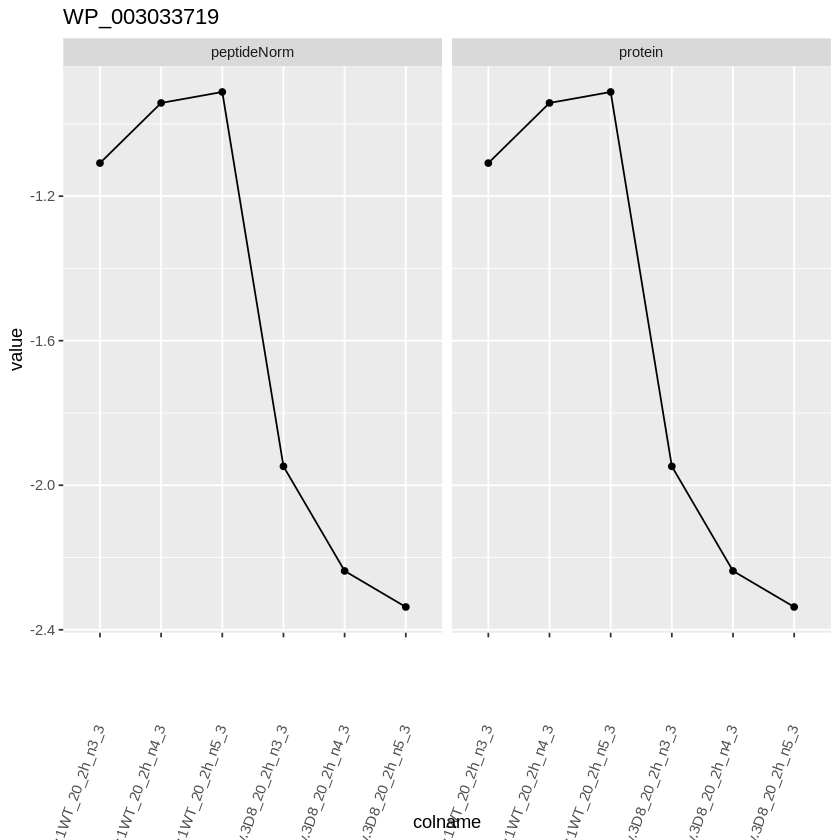

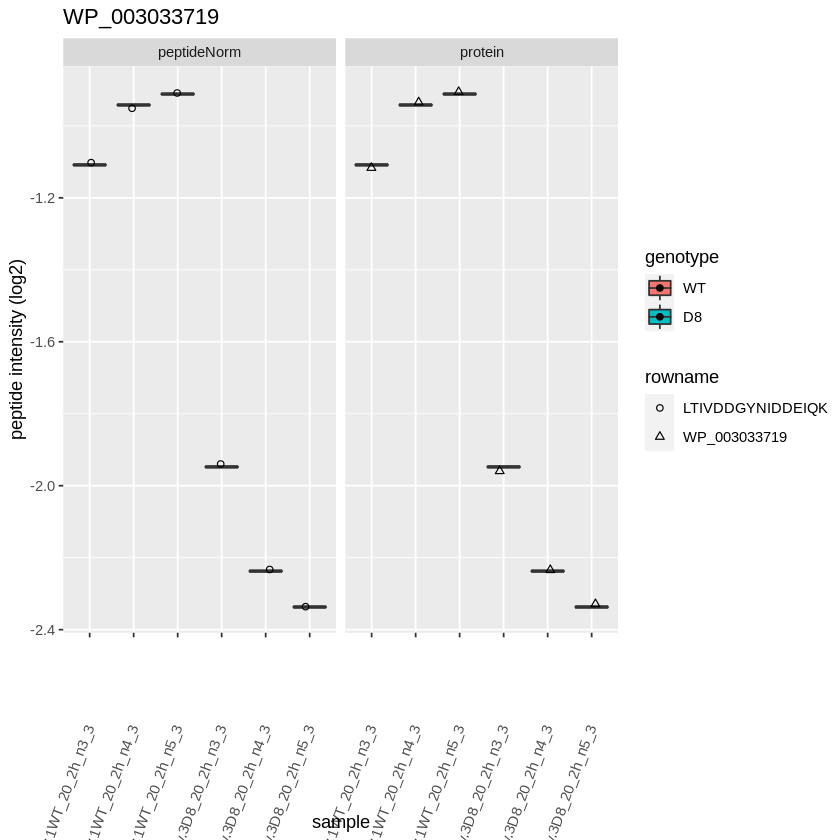

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



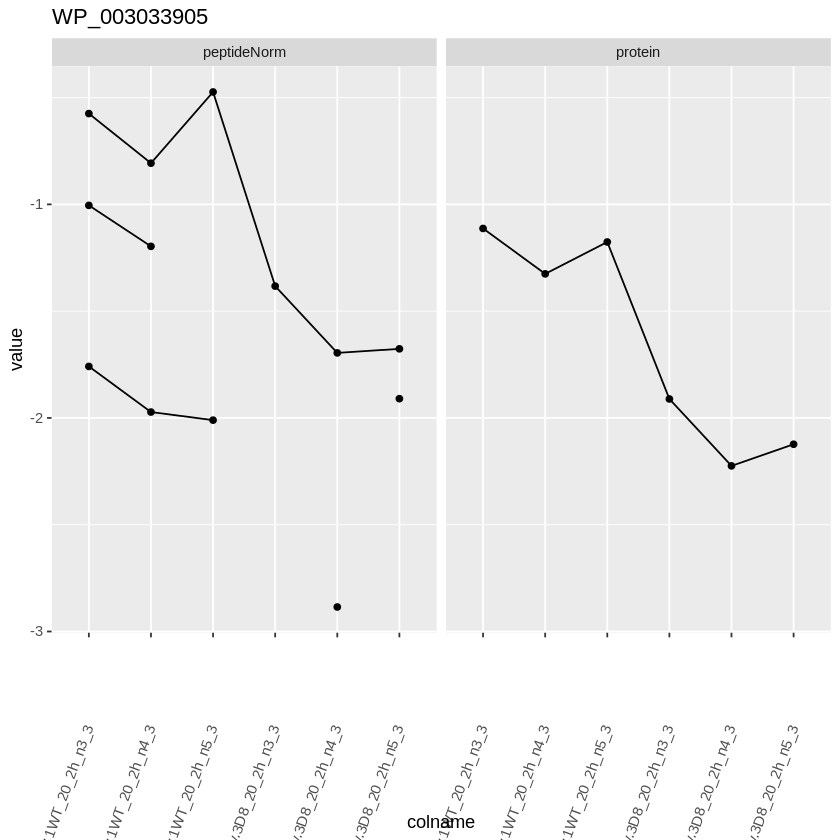

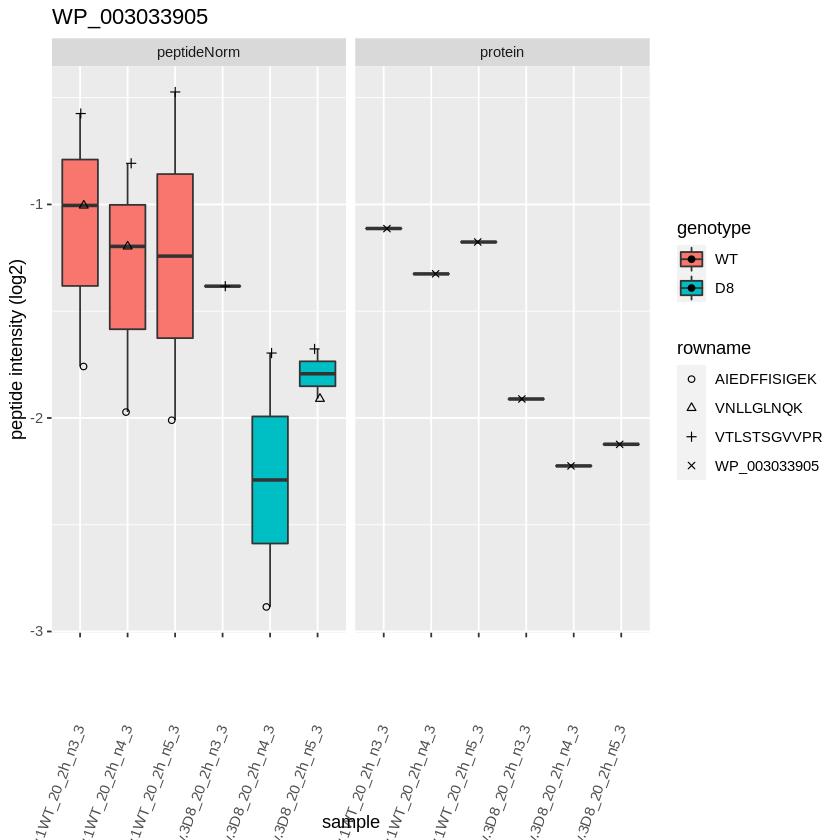

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



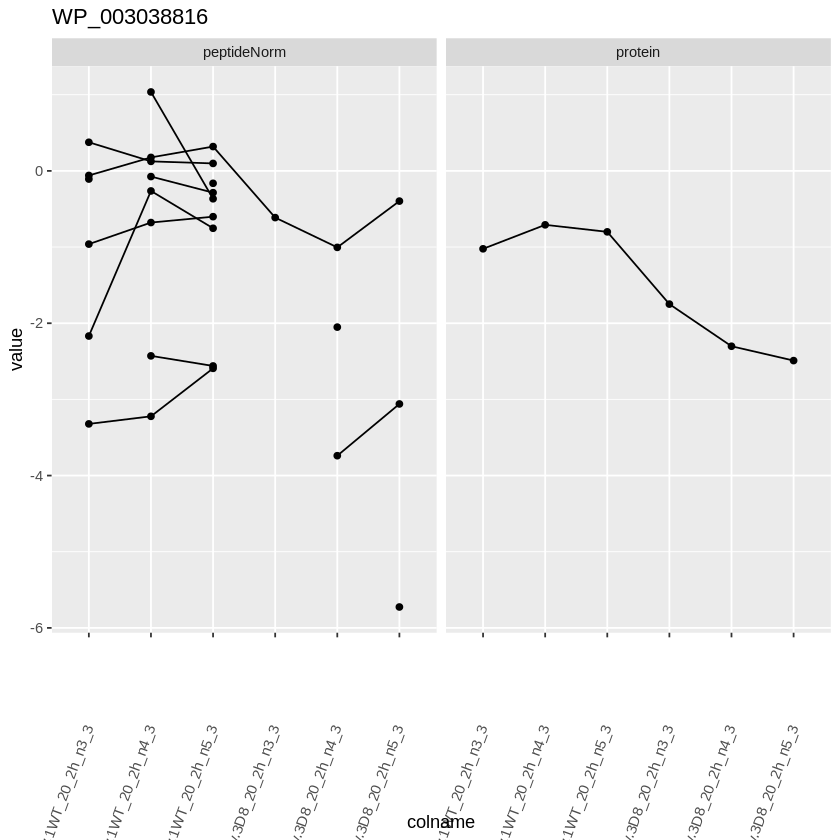

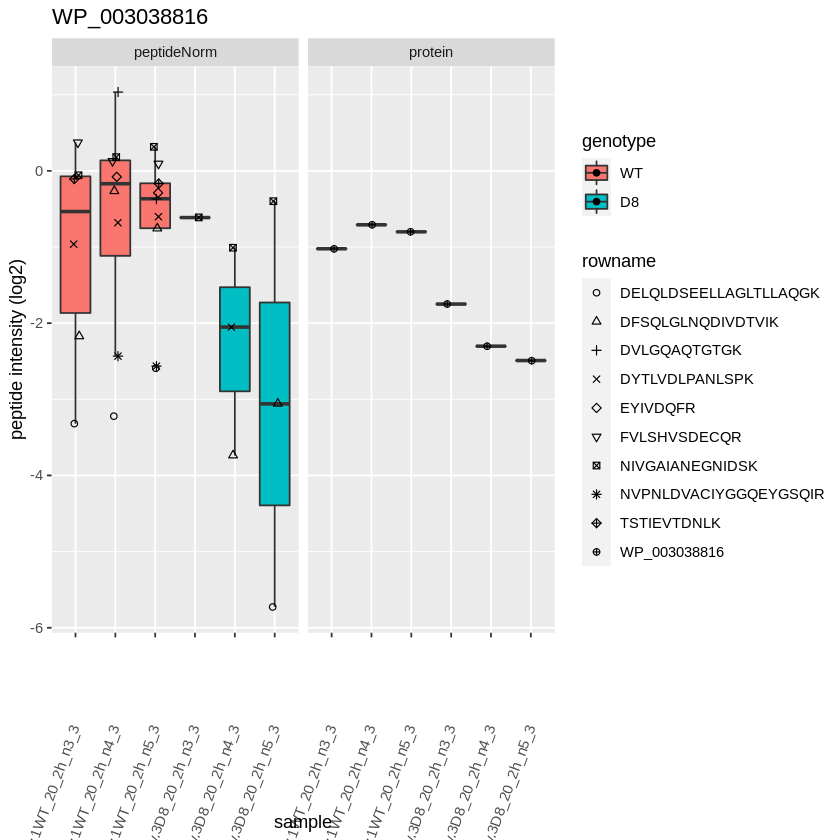

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



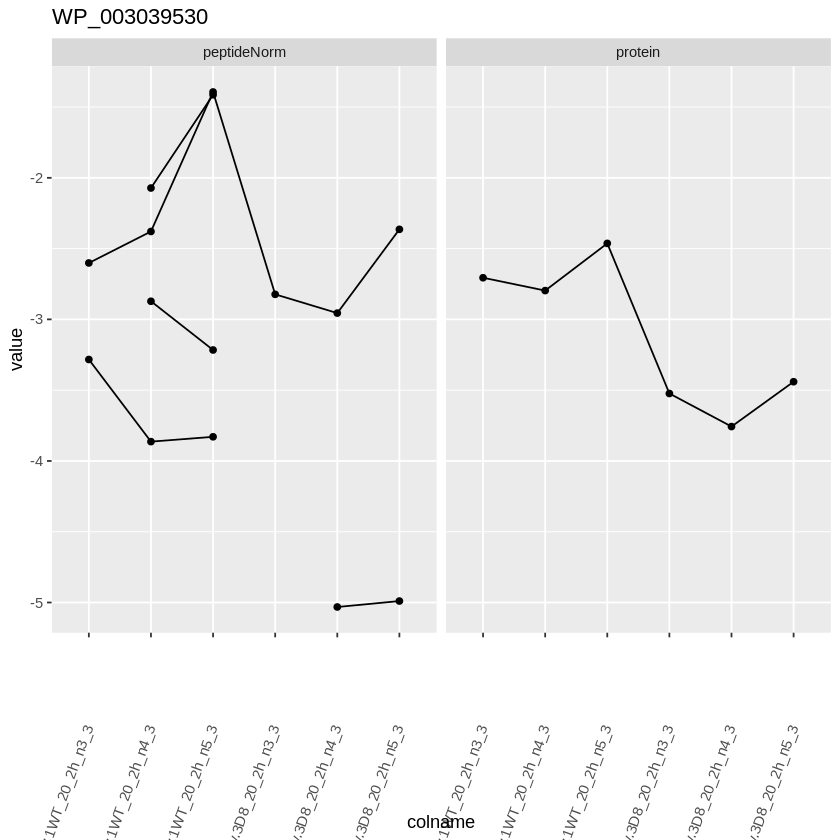

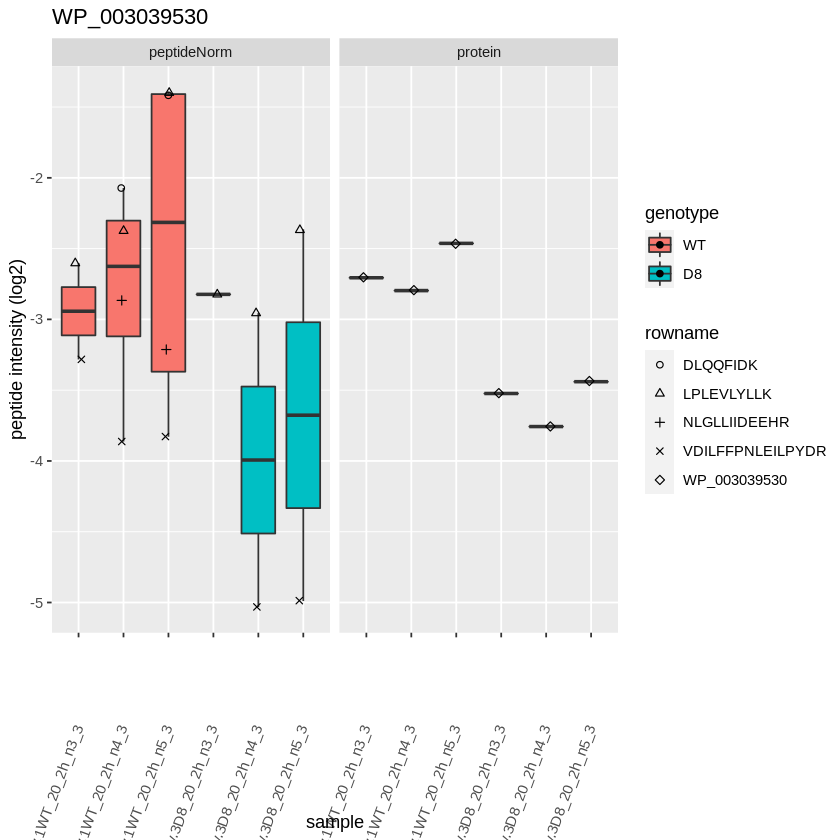

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



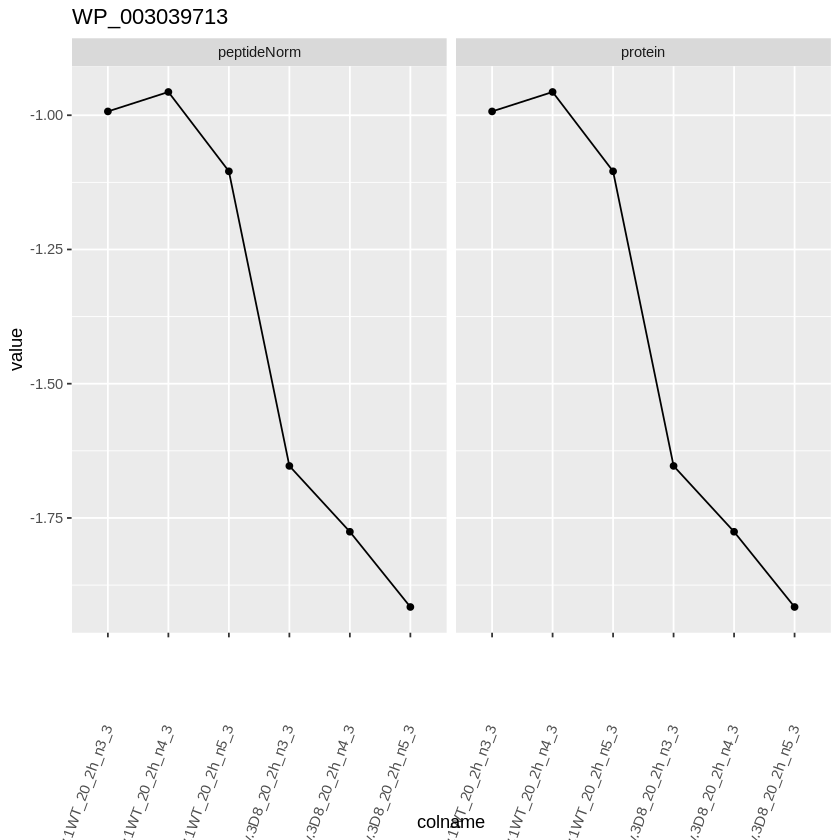

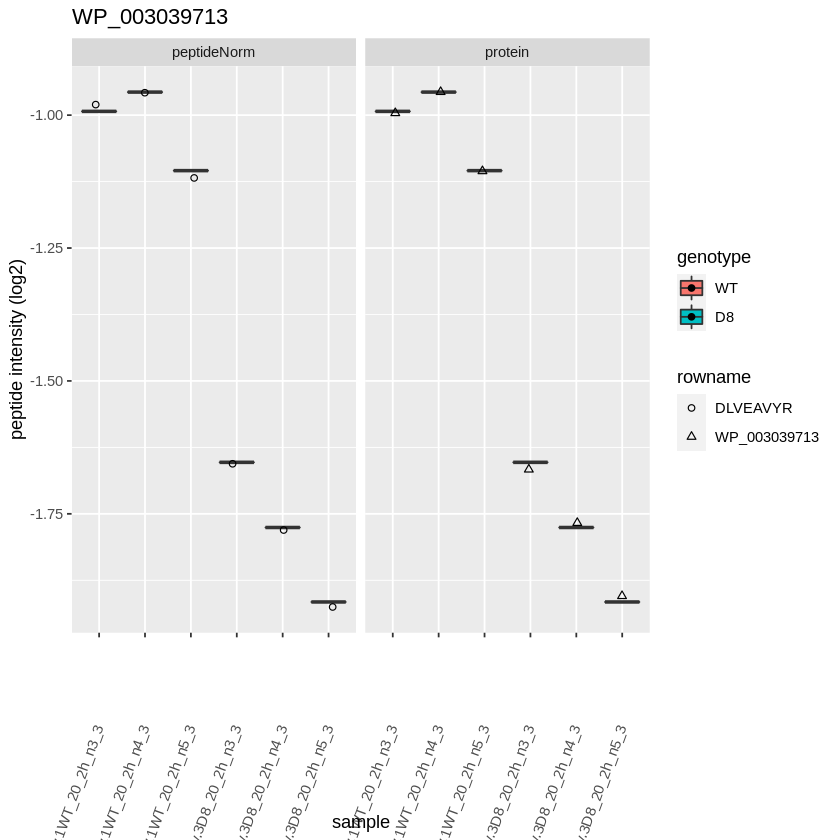

harmonizing input:
  removing 12 sampleMap rows not in names(experiments)



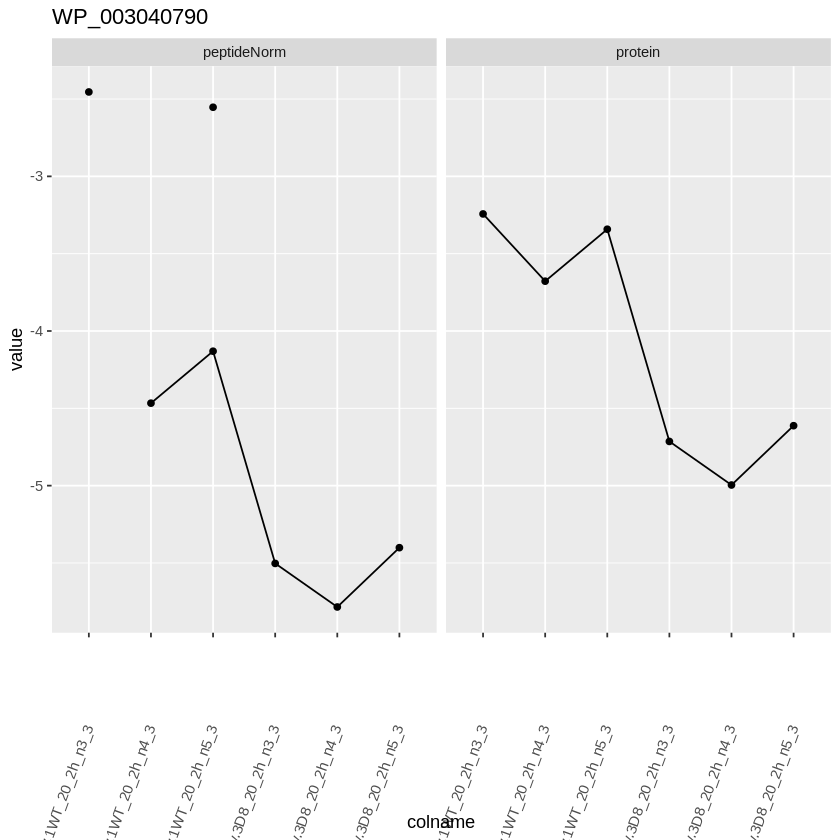

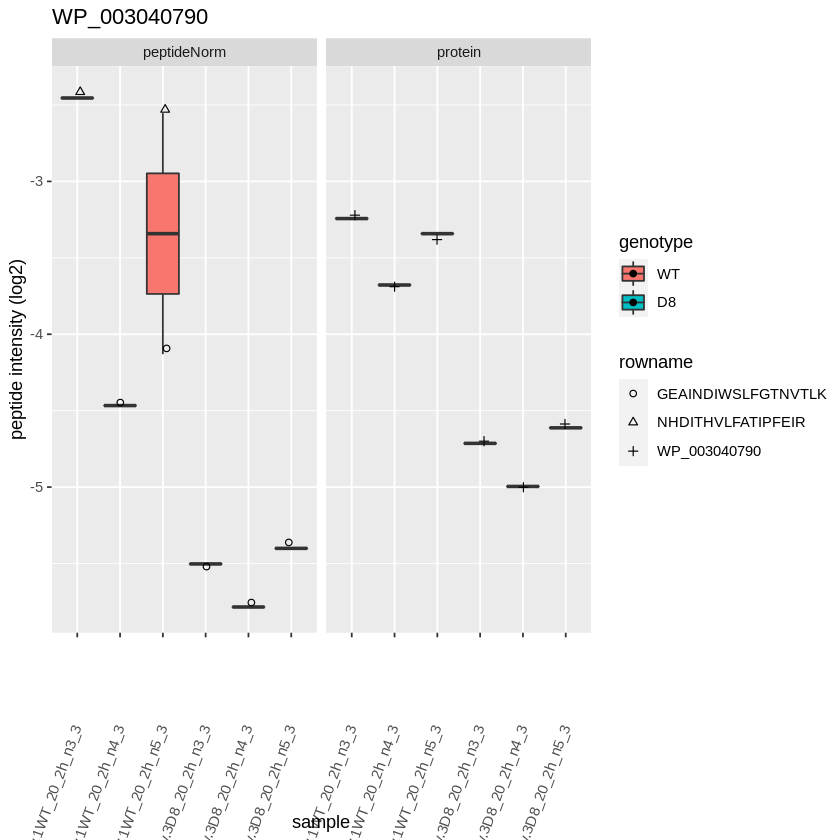

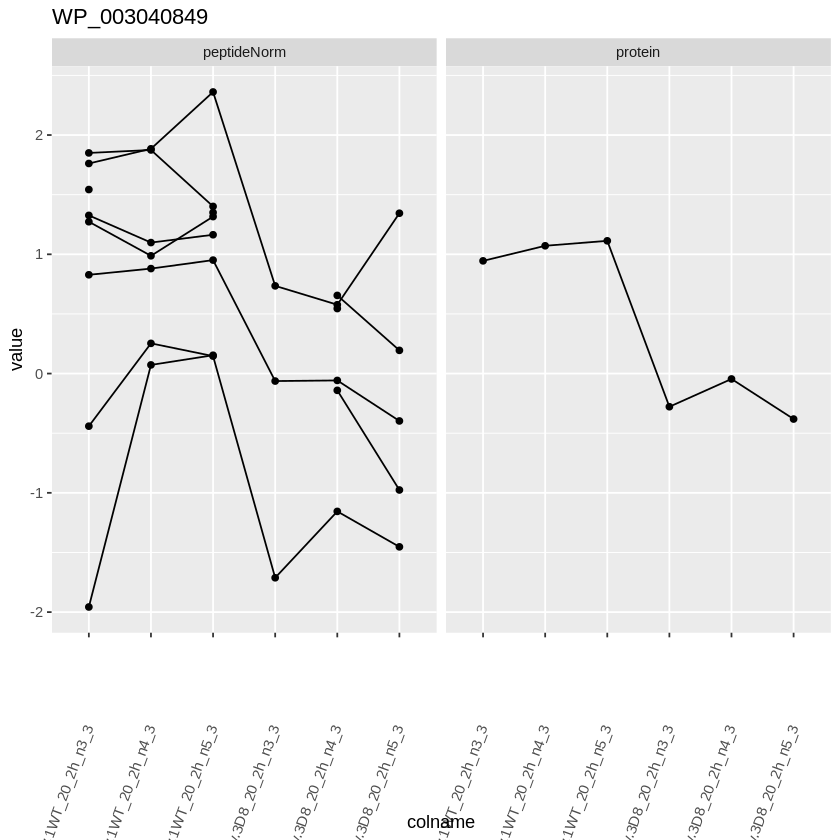

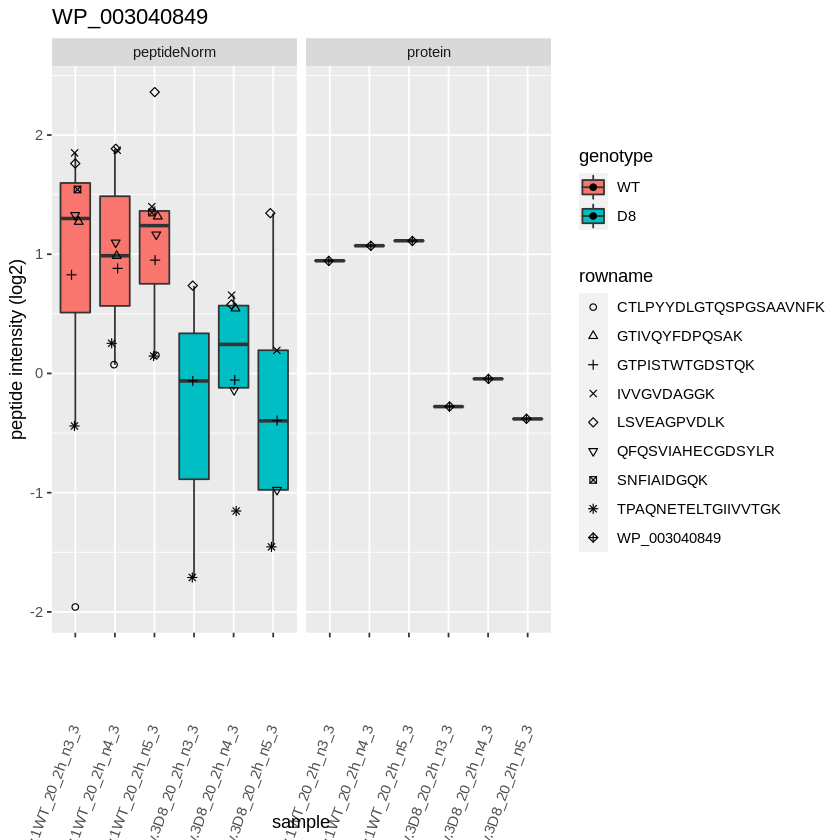

In [ ]:
for (protName in sigNames)
    {
        pePlot <- pe[protName, , c("peptideNorm", "protein")]
        pePlotDf <- data.frame(longFormat(pePlot))
        pePlotDf$assay <- factor(pePlotDf$assay,
            levels = c("peptideNorm", "protein")
        )
        pePlotDf$genotype <- as.factor(colData(pePlot)[pePlotDf$colname, "genotype"])

        # plotting
        p1 <- ggplot(
            data = pePlotDf,
            aes(x = colname, y = value, group = rowname)
        ) +
            geom_line() +
            geom_point() +
            facet_grid(~assay) +
            theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 0.5)) +
            ggtitle(protName)
        print(p1)

        # plotting 2
        p2 <- ggplot(pePlotDf, aes(x = colname, y = value, fill = genotype)) +
            geom_boxplot(outlier.shape = NA) +
            geom_point(
                position = position_jitter(width = .1),
                aes(shape = rowname)
            ) +
            scale_shape_manual(values = 1:nrow(pePlotDf)) +
            labs(title = protName, x = "sample", y = "peptide intensity (log2)") +
            theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 0.5)) +
            facet_grid(~assay)
        print(p2)
}

- experimental design

1) sample size

2) [blocking](https://www.nature.com/articles/nmeth.3005.pdf)

biological: fluctuations in protein level between mice, fluctuations in protein level between cells

technical: cage effect, lab effect, week effect, plasma extraction, MS-run

## Wrap Up

In [ ]:
peptidesFile <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/mouseTcell/peptidesRCB.txt"
peptidesFile2 <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/mouseTcell/peptidesCRD.txt"
peptidesFile3 <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/mouseTcell/peptides.txt"

ecols <- grep("Intensity\\.", names(read.delim(peptidesFile)))
pe <- readQFeatures(
  table = peptidesFile,
  fnames = 1,
  ecol = ecols,
  name = "peptideRaw", sep="\t")

ecols2 <- grep("Intensity\\.", names(read.delim(peptidesFile2)))
pe2 <- readQFeatures(
  table = peptidesFile2,
  fnames = 1,
  ecol = ecols2,
  name = "peptideRaw", sep="\t")

ecols3 <- grep("Intensity\\.", names(read.delim(peptidesFile3)))
pe3 <- readQFeatures(
  table = peptidesFile3,
  fnames = 1,
  ecol = ecols3,
  name = "peptideRaw", sep="\t")

### Design
colData(pe)$celltype <- substr(
  colnames(pe[["peptideRaw"]]),
  11,
  14) %>%
  unlist %>%  
  as.factor

colData(pe)$mouse <- pe[[1]] %>%
  colnames %>%
  strsplit(split="[.]")  %>%
  sapply(function(x) x[3]) %>%
  as.factor

colData(pe2)$celltype <- substr(
  colnames(pe2[["peptideRaw"]]),
  11,
  14) %>%
  unlist %>%  
  as.factor

colData(pe2)$mouse <- pe2[[1]] %>%
  colnames %>%
  strsplit(split="[.]")  %>%
  sapply(function(x) x[3]) %>%
  as.factor

colData(pe3)$celltype <- substr(
  colnames(pe3[["peptideRaw"]]),
  11,
  14) %>%
  unlist %>%  
  as.factor

colData(pe3)$mouse <- pe3[[1]] %>%
  colnames %>%
  strsplit(split="[.]")  %>%
  sapply(function(x) x[3]) %>%
  as.factor


In [ ]:
# preprocessing

logTransform_file <- function(pe) {
  # 1) calculate how many nonzero intensities we have for each peptide 
  rowData(pe[["peptideRaw"]])$nNonZero <- rowSums(assay(pe[["peptideRaw"]]) > 0)
  # 2) peptides w/ zero intensities are missing peptides -> convert to NA
  pe <- zeroIsNA(pe, "peptideRaw") # convert 0 to NA
  # 3) logtransform data w/ base 2
  pe <- logTransform(pe, base = 2, i = "peptideRaw", name = "peptideLog")

  return(pe)
}

pe1 <- logTransform_file(pe)
pe2 <- logTransform_file(pe2)
pe3 <- logTransform_file(pe3)

In [ ]:
# filtering
filtering <- function(pe) {
  # 1. overlapping proteins
  pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$Proteins %in%
                      smallestUniqueGroups(rowData(pe[['peptideLog']])$Proteins), ]
  # 2. remove reverse sequences(decoys) and contaminants
  pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Reverse != "+", ]
  pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$
      Potential.contaminant != "+", ]                      

  # 3. drop peptides that were identified in only 1 sample
  pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$nNonZero >= 2, ]
  nrow(pe[["peptideLog"]])    

  return(pe)
}

pe1 <- filtering(pe1)
pe2 <- filtering(pe2)
pe3 <- filtering(pe3)

In [ ]:
# normalize

normalize_pe <- function(pe) {
  pe <- normalize(pe,
                  i = 'peptideLog',
                  name = 'peptideNorm',
                  method = 'center.median')
 return(pe)               
}

pe1 <- normalize_pe(pe1)
pe2 <- normalize_pe(pe2)
pe3 <- normalize_pe(pe3)

In [ ]:
# summarization
summarize_pe <- function(pe) { 
  pe <- aggregateFeatures(pe,
                          i = 'peptideNorm',
                          fcol = 'Proteins',
                          na.rm = T,
                          name = 'protein')
 return(pe)                         
}

pe1 <- summarize_pe(pe1)
pe2 <- summarize_pe(pe2)
pe3 <- summarize_pe(pe3)

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.



In [ ]:
# Blocking

plot_blocking_effects <- function(pe, n, title) {
  levels(colData(pe)$mouse) <- paste0('m', 1:n)
  mdsObj <- plotMDS(assay(pe[['protein']]), plot = F)
  mdsDes <- colData(pe) %>%
    as.data.frame %>%
    mutate(mds1 = mdsObj$x,
          mds2 = mdsObj$y,
          lab = paste(mouse, celltype, sep='_')) %>%
    ggplot(aes(x = mds1, y = mds2, label = lab, color = celltype, group = mouse)) + 
      geom_text(show.legend = FALSE) +
      geom_point(shape = 21) +
      geom_line(color = "black", linetype = "dashed") +
      xlab(
        paste0(
          mdsObj$axislabel,
          " ",
          1, 
          " (",
          paste0(
            round(mdsObj$var.explained[1] *100,0),
            "%"
            ),
          ")"
          )
        ) +
      ylab(
        paste0(
          mdsObj$axislabel,
          " ",
          2, 
          " (",
          paste0(
            round(mdsObj$var.explained[2] *100,0),
            "%"
            ),
          ")"
          )
        ) +
      ggtitle(title)
  mdsObj
  mdsDes          
}

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



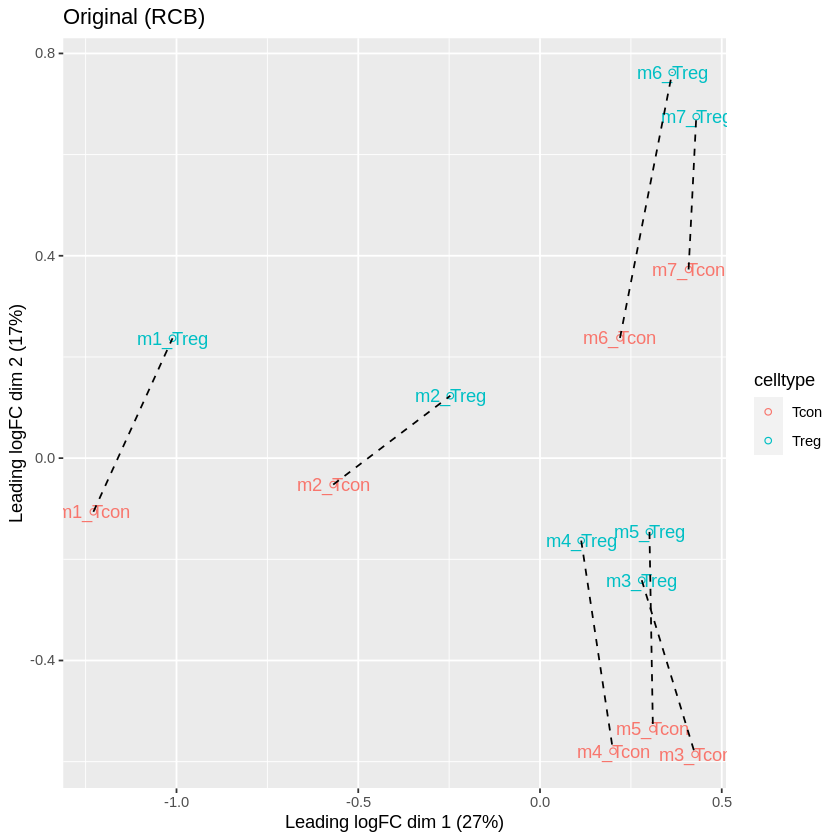

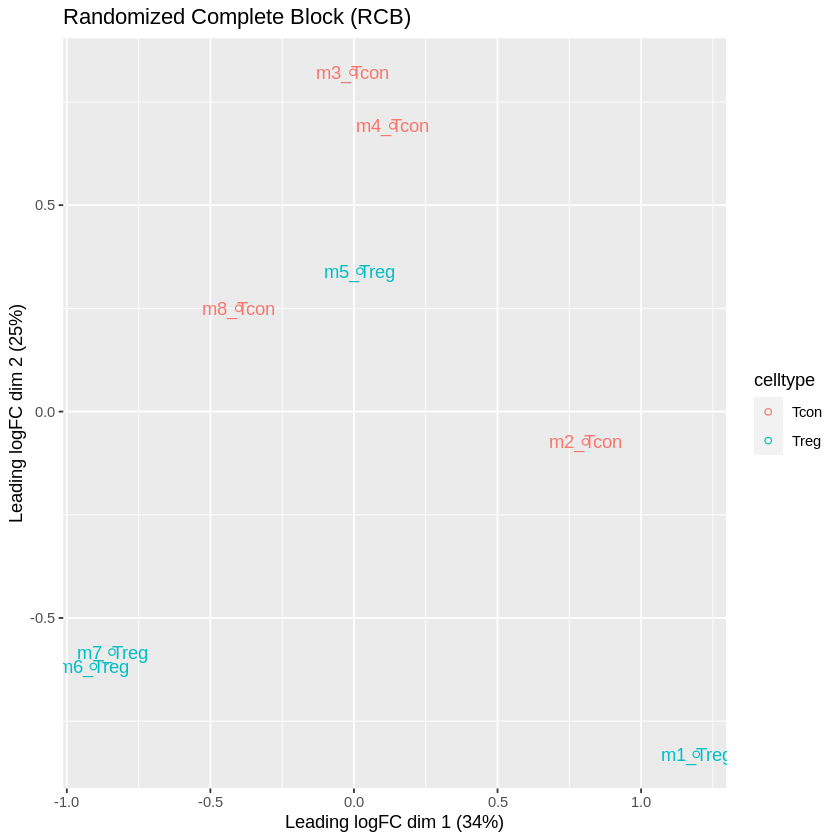

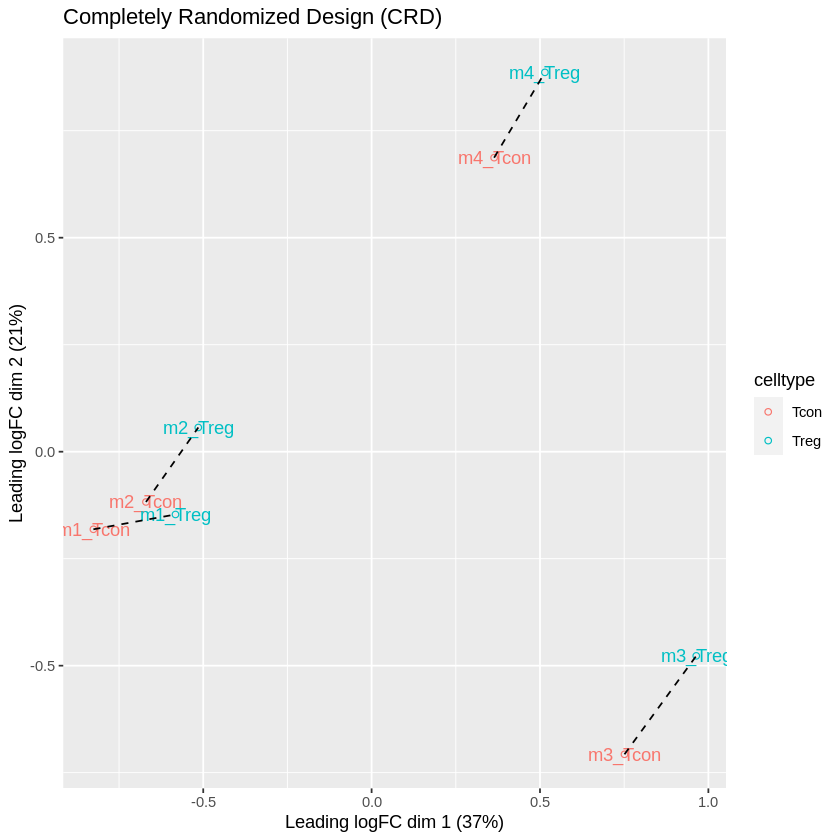

In [ ]:
plot_blocking_effects(pe3, 7, 'Original (RCB)')
plot_blocking_effects(pe2, 8, "Randomized Complete Block (RCB)")
plot_blocking_effects(pe1, 4, "Completely Randomized Design (CRD)")

- leading FC is according to mouse

- in the 2nd dimension we see a separation according to cell-type

- w/ RCB we can remove the mouse effect from analysis

In [ ]:
# RCB analysis

pe1 <- msqrob(object = pe1,
            i = 'protein',
            formula = ~ celltype + mouse)

# RCB wrong analysis
pe1 <- msqrob(object = pe1,
            i = 'protein',
            formula = ~ celltype, modelColumnName = 'wrongModel')

# CRD analysis
pe2 <- msqrob(object = pe2,
              i = 'protein',
              formula = ~ celltype)

[[1]]


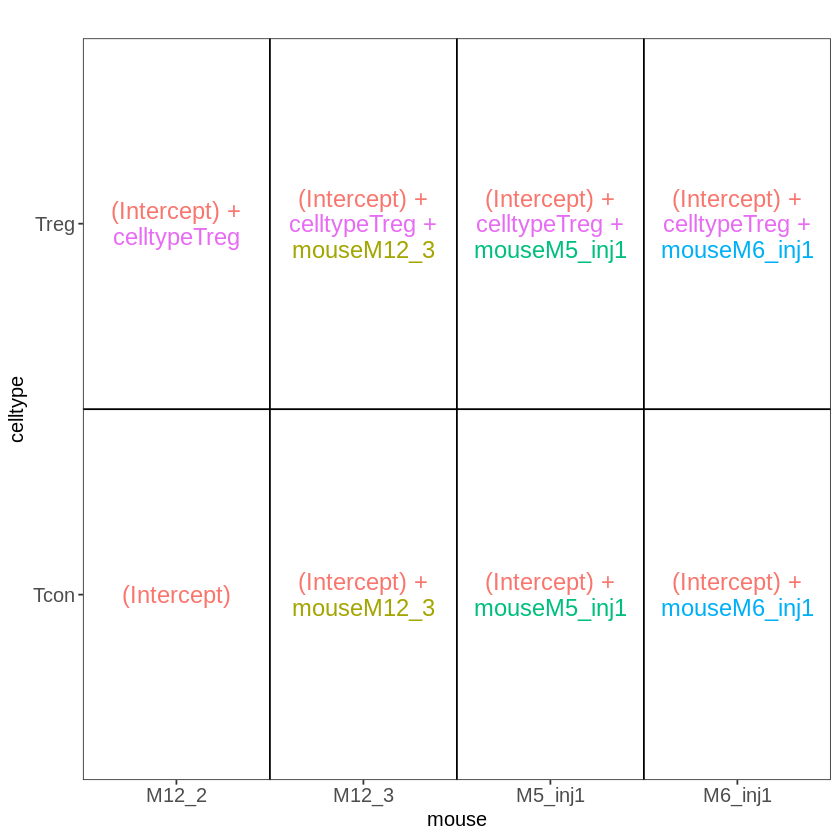

In [ ]:
library(ExploreModelMatrix)
VisualizeDesign(colData(pe), ~celltype + mouse)$plotlist

[[1]]


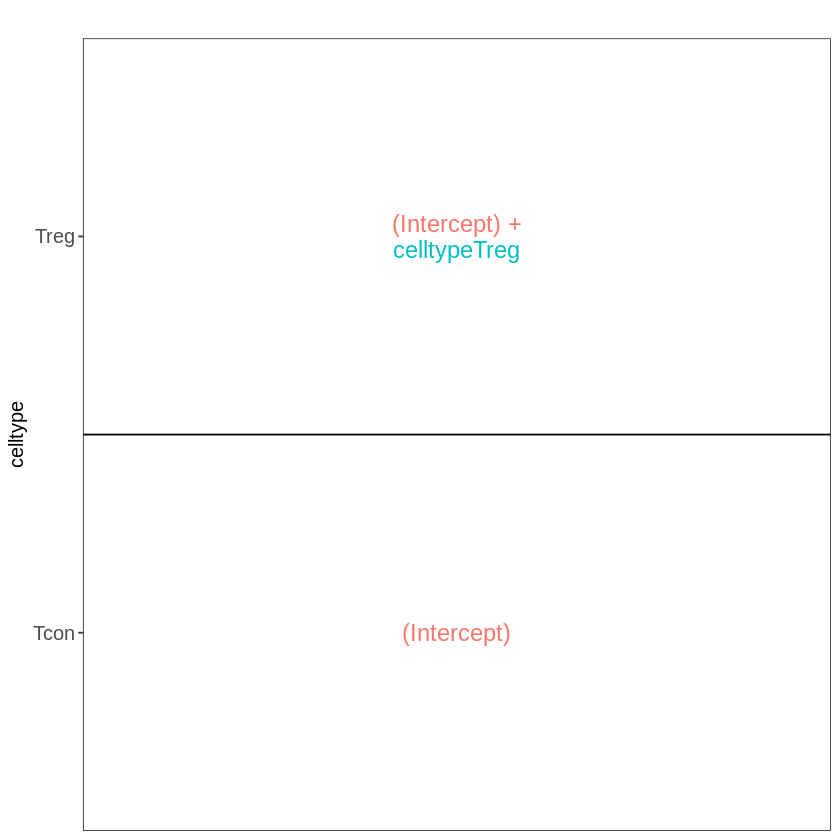

In [ ]:
VisualizeDesign(colData(pe2),~ celltype)$plotlist

In [ ]:
L <- makeContrast("celltypeTreg = 0", parameterNames = c("celltypeTreg"))
pe1 <- hypothesisTest(object = pe1, i = "protein", contrast = L)
pe1 <- hypothesisTest(object = pe1, i = "protein", contrast = L, modelColumn = "wrongModel", resultsColumnNamePrefix="wrong")
pe2 <- hypothesisTest(object = pe2, i = "protein", contrast = L)


In [ ]:
# advantage of blocking: comparison between designs
volcanoRCB <- ggplot(
    rowData(pe1[["protein"]])$celltypeTreg,
    aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)
) +
    geom_point(cex = 2.5) +
    scale_color_manual(values = alpha(c("black", "red"), 0.5)) +
    theme_minimal() +
    ggtitle(paste0("RCB: \n", 
                sum(rowData(pe1[["protein"]])$celltypeTreg$adjPval<0.05,na.rm=TRUE),
            " significant"))

volcanoRCBwrong <- ggplot(
    rowData(pe1[["protein"]])$wrongcelltypeTreg,
    aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)
) +
    geom_point(cex = 2.5) +
    scale_color_manual(values = alpha(c("black", "red"), 0.5)) +
    theme_minimal() +
    ggtitle(paste0("RCB wrong: \n", 
                sum(rowData(pe1[["protein"]])$wrongcelltypeTreg$adjPval<0.05,na.rm=TRUE),
            " significant"))

volcanoCRD <- ggplot(
    rowData(pe2[["protein"]])$celltypeTreg,
    aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)
) +
    geom_point(cex = 2.5) +
    scale_color_manual(values = alpha(c("black", "red"), 0.5)) +
    theme_minimal() +
    ggtitle(paste0("CRD: \n", 
                sum(rowData(pe2[["protein"]])$celltypeTreg$adjPval<0.05,na.rm=TRUE),
            " significant"))

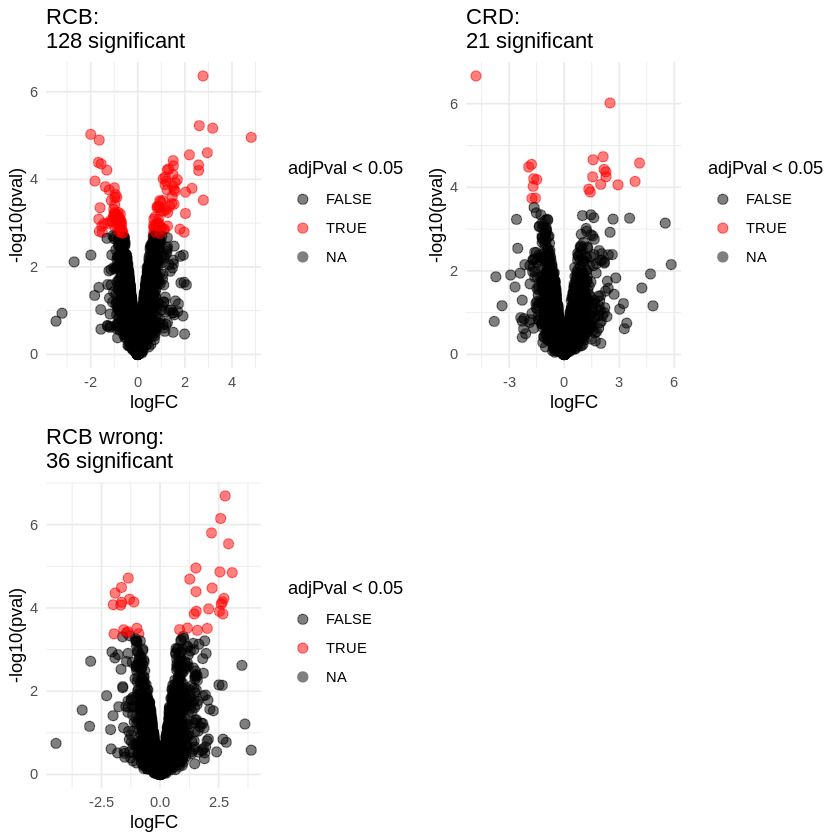

In [ ]:
grid.arrange(volcanoRCB, volcanoCRD, volcanoRCBwrong, ncol=2)

In [ ]:
accessions <- rownames(pe1[["protein"]])[rownames(pe1[["protein"]])%in%rownames(pe2[["protein"]])]
dat <- data.frame(
sigmaRBC = sapply(rowData(pe1[["protein"]])$msqrobModels[accessions], getSigmaPosterior),
sigmaRBCwrong = sapply(rowData(pe1[["protein"]])$wrongModel[accessions], getSigmaPosterior),
sigmaCRD <- sapply(rowData(pe2[["protein"]])$msqrobModels[accessions], getSigmaPosterior)
)

 plotRBCvsWrong <- ggplot(data = dat, aes(sigmaRBC, sigmaRBCwrong)) +
    geom_point(alpha = 0.1, shape = 20) +
    scale_x_log10() +
    scale_y_log10() +
    geom_abline(intercept=0,slope=1)
plotCRDvsWrong <- ggplot(data = dat, aes(sigmaCRD, sigmaRBCwrong)) +
    geom_point(alpha = 0.1, shape = 20) +
    scale_x_log10() +
    scale_y_log10() +
    geom_abline(intercept=0,slope=1)
plotRBCvsCRD <- ggplot(data = dat, aes(sigmaRBC, sigmaCRD)) +
    geom_point(alpha = 0.1, shape = 20) +
    scale_x_log10() +
    scale_y_log10() +
    geom_abline(intercept=0,slope=1)

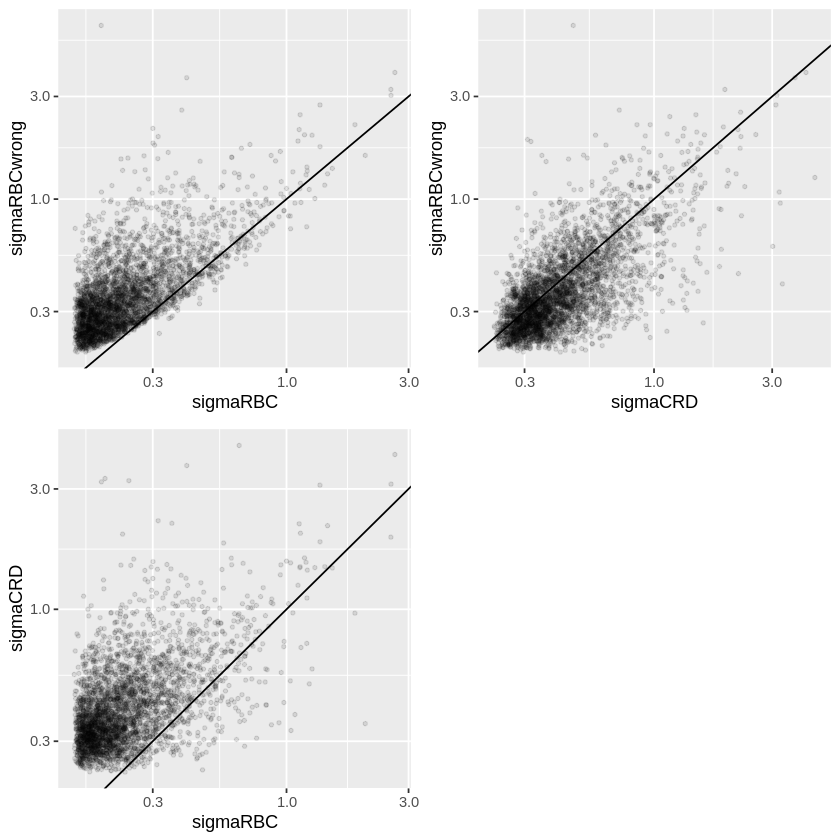

In [ ]:
grid.arrange(plotRBCvsWrong, plotCRDvsWrong, plotRBCvsCRD, nrow=2)

- observe that the standard deviation of the protein expression in the RCB is smaller for the majority of the proteins than that obtained w/ CRD

- standard deviation of the protein expression RCB where we perform a wrong analysis w/o considering the blocking factor according to mouse is much larger for the majority of the proteins than that obtained w/ the correct analysis

- indeed, when we ignore the blocking factor in the RCB design we don't remove the variability according to mouse from the analysis and the mouse effect is absorbed in the error term. The standard deviation than becomes very comparable to that observed in the completely randomised design where we couldn't remvoe the mouse effect from the analysis

- why are some of the standard deviation for the RCB w/ the correct analysis larger than that of the RCB w/ the incorrect analysis that ignored the mouse blocking factor?

- why would it not be useful to block on a particular factor?

## Tutorial

[link](https://statomics.github.io/PDA21/pda_tutorialDesign.html)

For proteomics experiments it is important to differentiate between experimental units and observational units. Experimental units are the subjects/objects on which one applies a given treatment, often also denoted as biological repeats. In a proteomics experiment, the number of experimental units is typically rather limited (e.g. three biological repeats of a knockout and three for a wild-type sample). The measurements, however, are gathered on the observational units. In a shotgun proteomics experiment, these are the individual peptide intensities.

For many proteins, there are thus multiple observations/peptide intensities for each experimental unit, which can be considered as technical replicates or pseudo-replicates.
There are two methods to deal with pseudo-replication at the peptide-level.

1. Summarize the peptide intensities into a protein expression value for each protein in the preprocessing and specify the statistical model at the protein level. Indeed, we no-longer have pseudo-replication at the protein level.

2. Model the peptide intensities using a mixed model with a random effect for sample, which will model the correlation between peptides for the same protein in the same sample.